In [3]:
# Standardbibliothek
import itertools
from collections import Counter
from itertools import product

# SciPy
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.optimize import linear_sum_assignment
from scipy.stats import zscore

# scikit-learn
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.model_selection import ParameterGrid

# Drittanbieter-Pakete
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
import umap

# Matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2025-06-09 21:16:39.096393: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 21:16:39.100073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 21:16:39.112936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 21:16:39.134337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

# Read data

## Indicators

In [4]:
# Dateien einlesen
part1 = pd.read_pickle('pkl/year_df_part1.pkl')
part2 = pd.read_pickle('pkl/year_df_part2.pkl')

# Zusammenführen
year_df_combined = pd.concat([part1, part2], ignore_index=True)
year_df_combined

Country Code ContinentCode  Year  Agricultural land sq. km.  \
0      Afghanistan  AFG            AS  1960                        NaN   
1      Afghanistan  AFG            AS  1961                   377500.0   
2      Afghanistan  AFG            AS  1962                   378000.0   
3      Afghanistan  AFG            AS  1963                   378500.0   
4      Afghanistan  AFG            AS  1964                   379050.0   
...            ...  ...           ...   ...                        ...   
13687       Zambia  ZMB            AF  2028                        NaN   
13688     Zimbabwe  ZWE            AF  2025                        NaN   
13689     Zimbabwe  ZWE            AF  2026                        NaN   
13690     Zimbabwe  ZWE            AF  2027                        NaN   
13691     Zimbabwe  ZWE            AF  2028                        NaN   

       Crop production index (2004-2006 = 100)  Precipitation mm per year  \
0                                          NaN                        NaN   
1                                         43.2                      327.0   
2                                         44.1                      327.0   
3                                         43.0                      327.0   
4                                         46.9                      327.0   
...                                        ...                        ...   
13687                                      NaN                        NaN   
13688                                      NaN                        NaN   
13689                                      NaN                        NaN   
13690                                      NaN                        NaN   
13691                                      NaN                        NaN   

       Arable land percent of total land area  Cereal yield kg per hectar  \
0                                         NaN                         NaN   
1                                        11.7                      1115.0   
2                                        11.8                      1079.0   
3                                        11.9                       986.0   
4                                        12.0                      1083.0   
...                                       ...                         ...   
13687                                     NaN                         NaN   
13688                                     NaN                         NaN   
13689                                     NaN                         NaN   
13690                                     NaN                         NaN   
13691                                     NaN                         NaN   

       Food production index (2004-2006 = 100)  ...  \
0                                          NaN  ...   
1                                         41.0  ...   
2                                         41.3  ...   
3                                         41.2  ...   
4                                         44.6  ...   
...                                        ...  ...   
13687                                      NaN  ...   
13688                                      NaN  ...   
13689                                      NaN  ...   
13690                                      NaN  ...   
13691                                      NaN  ...   

       Electricity consumption billion kilowatthours  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
...                                              ...   
13687                                            NaN   
13688                                            NaN   
13689                                            NaN   
13690                                            Na

In [5]:
year_df_combined.columns

Index(['Country', 'Code', 'ContinentCode', 'Year', 'Agricultural land sq. km.',
       'Crop production index (2004-2006 = 100)', 'Precipitation mm per year',
       'Arable land percent of total land area', 'Cereal yield kg per hectar',
       'Food production index (2004-2006 = 100)',
       ...
       'Electricity consumption billion kilowatthours',
       'Electricity imports billion kilowatthours',
       'Electricity exports billion kilowatthours',
       'Renewable power capacity million kilowatts',
       'Renewable power generation billion kilowatthours',
       'Natural gas production', 'Natural gas consumption',
       'Biofuels production', 'Biofuels consumption',
       'Prime energy production'],
      dtype='object', length=442)

## Metadata

In [6]:
metadata = pd.read_pickle('pkl/metadata.pkl')
metadata.head()

Indicator                 Measure  \
0                       Population size, in millions                 million   
1                          Life expectancy, in years                   years   
2                           Percent urban population                 percent   
3  The number of crude births per 1000 people, pe...  births per 1000 people   
4                        Death rate, per 1000 people  deaths per 1000 people   

                                   Source Currencies  \
0      United Nations Population Division              
1  The United Nations Population Division              
2      United Nations Population Division              
3                          The World Bank              
4                          The World Bank              

                                          Definition    Time  \
0  Total population is based on the de facto defi...  annual   
1  Life expectancy at birth indicates the number ...  annual   
2  Urban population refers to people living in ur...  annual   
3  Crude birth rate indicates the number of live ...  annual   
4  Crude death rate indicates the number of death...  annual   

                          Group  
0                  Demographics  
1  Health spending and outcomes  
2                  Demographics  
3  Health spending and outcomes  
4  Health spending and outcomes

In [7]:
year_df_combined.columns = year_df_combined.columns.str.replace(',', '', regex=False)
metadata['Indicator'] = metadata['Indicator'].astype(str).str.replace(',', '', regex=False)

# Liste der Spaltennamen ab der 2. Spalte (Index 1)
spalten_liste = year_df_combined.columns[4:].tolist()

# Liste der Werte in der Spalte 'Merkmale' von df2
merkmale_liste = metadata['Indicator'].tolist()

# Vergleich: Welche Merkmale aus df2 sind in df1 enthalten?
gemeinsam = list(set(spalten_liste) & set(merkmale_liste))
nur_in_df1 = list(set(spalten_liste) - set(merkmale_liste))
nur_in_df2 = list(set(merkmale_liste) - set(spalten_liste))

#print("Gemeinsame Merkmale:", gemeinsam)
print("Nur in df1:", nur_in_df1)
print("Nur in df2:", nur_in_df2)
print("Nur in df2:", len(gemeinsam))

Nur in df1: []
Nur in df2: ['Retail sales index', 'Economic growth percent change in quarterly real GDP', 'Business confidence survey', 'Consumer confidence survey', 'Economic growth quarterly', 'GDP billion currency units', 'Retail sales Y-on-Y', 'Industrial production annual percent change', 'House price index', 'Real residential property prices Y-on-Y percent change']
Nur in df2: 438


# Data Analysis

In [ ]:
# Optional: bessere Formatierung in Jupyter
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [ ]:
desired_columns = [
    'Industry value added billion USD',
    'Manufacturing value added billion USD',
    'Population size in millions',
    'Capital investment as percent of GDP',
    'Economic growth: the rate of change of real GDP',
    'Economic decline index 0 (low) - 10 (high)',
    'Economic freedom overall index (0-100)',
    'Gross Domestic Product billions of U.S. dollars',
    'Population growth percent',
    'Business freedom index (0-100)',
    'Trade freedom index (0-100)',
    'Economic globalization index (0-100)',
    'Literacy rate'
]

# Nur die ersten 4 Spalten und die gewünschten behalten
df_filtered = year_df_combined.iloc[:, :4].join(year_df_combined[desired_columns])
df = df_filtered

## Initial Data Analysis (IDA)

### Checking Form & Struktur

In [ ]:
df.shape

### Checking Datentypen

In [ ]:
df.columns

In [ ]:
df.info()

### Checking first & last rows

In [ ]:
df.head(10)

In [ ]:
df.tail()

### Checking Missing Values

In [ ]:
# Übersicht zu fehlenden Werten
df.isnull().sum().sort_values(ascending=False)

### Checking latest year for features

In [ ]:
pivot_df = pd.melt(df, id_vars=['Country', 'Code', 'ContinentCode', 'Year'], var_name='Indicator', value_name='Value')

# Wählen Sie die Jahre aus, die Sie überprüfen möchten
jahre_liste = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

# Ergebnis-DataFrame initialisieren
result_df_all_years = pd.DataFrame()

# Iteration über die ausgewählten Jahre
for year in jahre_liste:
    # Filtern Sie den DataFrame für das aktuelle Jahr
    pivot_df_year = pivot_df[pivot_df['Year'] == year]

    sum_all_1 = pivot_df_year.groupby('Indicator')['Value'].count()

    # Fügen Sie die Summen für das aktuelle Jahr als Spalten hinzu
    result_df_all_years[f'{year}'] = sum_all_1
    
# Anzeige des resultierenden DataFrames
result_df_all_years


In [ ]:
# Ursprüngliches DataFrame schmelzen (falls noch nicht gemacht)
pivot_df = pd.melt(df, id_vars=['Country', 'Code', 'ContinentCode', 'Year'], 
                   var_name='Indicator', value_name='Value')

# Wählen Sie die Jahre aus, die Sie überprüfen möchten
jahre_liste = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

# Ergebnis-DataFrame initialisieren
result_df_all_years = pd.DataFrame()

# Iteration über die ausgewählten Jahre
for year in jahre_liste:
    # Filter für das aktuelle Jahr
    pivot_df_year = pivot_df[pivot_df['Year'] == year]

    # Gruppierung nach Land statt nach Indikator
    sum_all_1 = pivot_df_year.groupby('Country')['Value'].count()

    # Zusammenführen in das Ergebnis-DataFrame
    result_df_all_years[f'{year}'] = sum_all_1

# Ergebnis anzeigen
result_df_all_years.head(40)


In [ ]:
# Gesamtanzahl der Werte pro Land über alle Jahre hinweg
result_df_all_years['Total'] = result_df_all_years.sum(axis=1)

# Sortieren nach der Gesamtanzahl
sorted_df = result_df_all_years.sort_values('Total')

# 5 Länder mit den wenigsten Werten
bottom_5 = sorted_df.head(10)

# 5 Länder mit den meisten Werten
top_5 = sorted_df.tail(10)

# Anzeige
print("5 Länder mit den wenigsten Werten:")
print(bottom_5)

print("\n5 Länder mit den meisten Werten:")
print(top_5)


In [ ]:
# Ursprüngliches DataFrame schmelzen (falls noch nicht gemacht)
pivot_df = pd.melt(df, id_vars=['Country', 'Code', 'ContinentCode', 'Year'], 
                   var_name='Indicator', value_name='Value')

# Wählen Sie die Jahre aus, die Sie überprüfen möchten
jahre_liste = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

# Ergebnis-DataFrame initialisieren
result_df_all_years = pd.DataFrame()

# Iteration über die ausgewählten Jahre
for year in jahre_liste:
    # Filter für das aktuelle Jahr
    pivot_df_year = pivot_df[pivot_df['Year'] == year]

    # Gruppierung nach Land statt nach Indikator
    sum_all_1 = pivot_df_year.groupby('ContinentCode')['Value'].count()

    # Zusammenführen in das Ergebnis-DataFrame
    result_df_all_years[f'{year}'] = sum_all_1

# Ergebnis anzeigen
result_df_all_years.head(40)


In [ ]:
df['ContinentCode'].unique()

In [ ]:
# Mapping Dictionary: ISO-Code → Englischer Name
continent_name_map = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America',
    'OC': 'Oceania',
    'AN': 'Antarctica'
}

# Index (ContinentCode) in neue Spalte übernehmen
df = df.reset_index()

# Englische Kontinentnamen hinzufügen
df['Continent'] = df['ContinentCode'].map(continent_name_map)

# Optional: Spaltenreihenfolge anpassen
cols = ['ContinentCode', 'Continent'] + [col for col in df.columns if col not in ['ContinentCode', 'Continent']]
df = df[cols]

# Ausgabe
df.head()

In [ ]:
df['ContinentCode'].unique()

In [ ]:
df[pd.isna(df['ContinentCode'])]['Country'].drop_duplicates().tolist()

In [ ]:
north_america_countries = [
    'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Belize', 'Bermuda',
    'Canada', 'Costa Rica', 'Dominica', 'Dominican Republic', 'El Salvador',
    'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico',
    'Nicaragua', 'Panama', 'Puerto Rico', 'Saint Lucia',
    'Saint Vincent and the Grenadines', 'Trinidad and Tobago',
    'USA', 'Cuba', 'Montserrat'
]

# Ergänze ggf. die fehlenden ContinentCodes in deinem DataFrame
df.loc[
    df['Country'].isin(north_america_countries),
    'ContinentCode'
] = 'NA'

# Danach kannst du das Mapping erneut anwenden
df['Continent'] = df['ContinentCode'].map(continent_name_map)

In [ ]:
# DataFrame schmelzen (falls noch nicht gemacht)
pivot_df = pd.melt(df, id_vars=['Country', 'Code', 'ContinentCode', 'Year'], 
                   var_name='Indicator', value_name='Value')

# Liste der Jahre
jahre_liste = [2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027]

# Ergebnis-DataFrame initialisieren
avg_entries_per_country = pd.DataFrame()

# Schleife über Jahre
for year in jahre_liste:
    # Jahr filtern
    year_df = pivot_df[pivot_df['Year'] == year]

    # Zähle Einträge pro Land innerhalb des Kontinents
    entries_per_country = year_df.groupby(['ContinentCode', 'Country'])['Value'].count()

    # Mittelwert pro Kontinent berechnen
    avg_per_continent = entries_per_country.groupby('ContinentCode').mean()

    # Zum Ergebnis-DataFrame hinzufügen
    avg_entries_per_country[f'{year}'] = avg_per_continent

# Auf eine Nachkommastelle runden
avg_entries_per_country = avg_entries_per_country.round(1)

# Ergebnis anzeigen
avg_entries_per_country.head(40)


### Checking unique values

In [ ]:
# Anzahl eindeutiger Werte pro Spalte
df.nunique().sort_values()

### Basic statistics

In [ ]:
# Grundstatistik
df.describe(include='all').T

### Detect outlieres

Z-Score

In [ ]:
# Jahr 2023 filtern
df_2023 = df[df['Year'] == 2023].copy()

# Länder mit fehlenden Werten identifizieren
missing_countries = df_2023[df_2023['Population size in millions'].isna()]['Country'].unique()

# Fehlende Länder ausgeben
print("Länder mit fehlender Bevölkerungszahl im Jahr 2023:")
for country in missing_countries:
    print("-", country)

# NaN-Werte entfernen
df_2023 = df_2023.dropna(subset=['Population size in millions'])

# Z-Score berechnen
df_2023['Z_Score'] = zscore(df_2023['Population size in millions'])

# Ausreißer mit |Z| > 0.1
outliers = np.abs(df_2023['Z_Score']) > 1.5
df_outliers = df_2023.loc[outliers, ['Country', 'Population size in millions', 'Z_Score']]

# Ergebnis anzeigen
df_outliers


In [ ]:
from scipy.stats import zscore
import numpy as np

# Jahr 2023 filtern
df_2023 = df[df['Year'] == 2023].copy()

# Länder mit fehlenden Werten identifizieren
missing_countries = df_2023[df_2023['Industry value added billion USD'].isna()]['Country'].unique()

# Fehlende Länder ausgeben
print("Länder mit fehlendem Industrie-BIP (in Mrd. USD) im Jahr 2023:")
for country in missing_countries:
    print("-", country)

# NaN-Werte entfernen
df_2023 = df_2023.dropna(subset=['Industry value added billion USD'])

# Z-Score berechnen
df_2023['Z_Score'] = zscore(df_2023['Industry value added billion USD'])

# Ausreißer mit |Z| > 0.1
outliers = np.abs(df_2023['Z_Score']) > 1.5
df_outliers = df_2023.loc[outliers, ['Country', 'Industry value added billion USD', 'Z_Score']]

# Ergebnis anzeigen
df_outliers


IQR

In [ ]:
# === Parameter definieren ===
column = 'Industry value added billion USD'  # Spalte, die analysiert wird
threshold = 5  # IQR-Faktor
year = 2023      # Jahr

# === 1. Daten für das Jahr 2023 filtern ===
df_year = df[df['Year'] == year].copy()

# === 2. NaN-Werte entfernen ===
df_clean = df_year.dropna(subset=[column])

# === 3. IQR-Grenzen berechnen ===
Q1 = df_clean[column].quantile(0.25)
Q3 = df_clean[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

print(f"\nIQR-Grenzen für '{column}' im Jahr {year}:")
print(f"  Untergrenze: {lower_bound:.2f}")
print(f"  Obergrenze:  {upper_bound:.2f}")

# === 4. Ausreißer identifizieren ===
outliers = (df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)
df_outliers = df_clean.loc[outliers, ['Country', column]]

# === 5. Ergebnis anzeigen ===
df_outliers

Visually: histograms

In [ ]:
# Kategorische Daten als "category" casten
categorical_columns = ['Country', 'Code', 'ContinentCode']
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [ ]:
num_cols = df_2023.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    col_data = df_2023[col].dropna()

    # Wenn Spalte nur NaNs enthält, überspringen
    if col_data.empty:
        print(f"Überspringe {col}: keine gültigen Werte.")
        continue

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogramm
    sns.histplot(col_data, kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Histogramm von {col}')

    # Boxplot
    sns.boxplot(x=col_data, ax=axes[1])
    axes[1].set_title(f'Boxplot von {col}')

    # Violinplot
    sns.violinplot(x=col_data, ax=axes[2])
    axes[2].set_title(f'Violinplot von {col}')

    plt.tight_layout()
    plt.show()


## Exploratory Data Analysis (EDA)

In [ ]:
# Stelle sicher, dass die Kontinent-Spalte korrekt benannt ist
continent_col = 'ContinentCode'

# Nur numerische Spalten
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # drei Spalten, eine Zeile

    # Histogramm pro Kontinent
    sns.histplot(data=df, x=col, hue=continent_col, kde=True, bins=30, ax=axes[0], multiple="stack")
    axes[0].set_title(f'Histogramm von {col} nach Kontinent')

    # Boxplot pro Kontinent
    sns.boxplot(data=df, x=continent_col, y=col, ax=axes[1])
    axes[1].set_title(f'Boxplot von {col} nach Kontinent')

    # Violinplot pro Kontinent
    sns.violinplot(data=df, x=continent_col, y=col, ax=axes[2])
    axes[2].set_title(f'Violinplot von {col} nach Kontinent')

    plt.tight_layout()
    plt.show()


In [ ]:
# Spaltennamen anpassen
continent_col = 'ContinentCode'
year_col = 'Year'

# Ab 2022 filtern
df_filtered = df[df[year_col] >= 2020].copy()

# Numerische Spalten ohne Jahr
num_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
num_cols = [col for col in num_cols if col != year_col]

for col in num_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogramm mit normalisierter Häufigkeit
    sns.histplot(
        data=df_filtered,
        x=col,
        hue=continent_col,
        kde=True,
        bins=30,
        ax=axes[0],
        multiple="layer",  # Optional: "stack" oder "dodge"
        stat="probability"  # Oder "density"
    )
    axes[0].set_title(f'Normiertes Histogramm von {col} nach Kontinent (ab 2022)')

    # Boxplot
    sns.boxplot(data=df_filtered, x=continent_col, y=col, ax=axes[1])
    axes[1].set_title(f'Boxplot von {col} nach Kontinent (ab 2022)')

    # Violinplot
    sns.violinplot(data=df_filtered, x=continent_col, y=col, ax=axes[2])
    axes[2].set_title(f'Violinplot von {col} nach Kontinent (ab 2022)')

    plt.tight_layout()
    plt.show()


### Correlation Matrix

In [ ]:
# Filter für Jahr >= 2020
df_filtered = df[df['Year'] >= 2020]

# Numerische Spalten auswählen, aber 'index' und 'Year' ausschließen
exclude_cols = ['index', 'Year']
num_cols = [col for col in df_filtered.select_dtypes(include=['float64', 'int64']).columns if col not in exclude_cols]

# Korrelationsmatrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(df_filtered[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Korrelationsmatrix (ab Jahr 2020, ohne Index/Year)')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('korrelationsmatrix.png', dpi=600)
plt.show()


### Pairplot

In [ ]:
# Drei ausgewählte Variablen
selected_cols = [
    'Literacy rate',
    'Population size in millions',
    'Gross Domestic Product billions of U.S. dollars'
]

# Achsentitel in zwei Zeilen umformatieren
label_map = {
    'Literacy rate': 'Literacy\nrate',
    'Population size in millions': 'Population size\n(in millions)',
    'Gross Domestic Product billions of U.S. dollars': 'GDP\n(bn USD)'
}

# Log-Skalierung anwenden (außer 'Literacy rate')
df_log = df[selected_cols].dropna().copy()
df_log[selected_cols[1:]] = df_log[selected_cols[1:]].apply(lambda x: np.log10(x + 1))

# Pairplot mit kleineren Punkten
g = sns.pairplot(
    df_log,
    height=2.5,
    aspect=1.2,
    plot_kws={'s': 10}
)

# Achsenbeschriftungen anpassen (2-zeilig, größer)
for ax in g.axes.flatten():
    if ax is not None:
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        if xlabel in label_map:
            ax.set_xlabel(label_map[xlabel], fontsize=10)
        if ylabel in label_map:
            ax.set_ylabel(label_map[ylabel], fontsize=10)
        ax.tick_params(axis='both', labelsize=8)

# Titel und Layout
plt.suptitle('Pairplot der ausgewählten Variablen (log10-skaliert)', y=1.02, fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Drei ausgewählte Variablen
selected_cols = [
    'Manufacturing value added billion USD',
    'Population size in millions',
    'Gross Domestic Product billions of U.S. dollars'
]

# Achsentitel in zwei Zeilen umformatieren
label_map = {
    'Manufacturing value added billion USD': 'Manufacturing value\nadded (bn USD)',
    'Population size in millions': 'Population size\n(in millions)',
    'Gross Domestic Product billions of U.S. dollars': 'GDP\n(bn USD)'
}

# Daten filtern: nur 2020–2023, keine NaN, 'Continent' einbeziehen
df_filtered = df[df['Year'].between(2020, 2023)].copy()
df_log = df_filtered[selected_cols + ['Continent']].dropna().copy()

# Log-Skalierung anwenden
df_log[selected_cols] = df_log[selected_cols].apply(lambda x: np.log10(x + 1))

# Pairplot mit hue=Continent
g = sns.pairplot(
    df_log,
    hue='Continent',
    height=2.5,
    aspect=1.2,
    plot_kws={'s': 10}
)

# Automatische Legende entfernen
if g._legend is not None:
    g._legend.remove()

# Farben aus Line2D-Objekten extrahieren
legend_elements = [
    Patch(facecolor=g._legend_data[label].get_color(), label=label)
    for label in g._legend_data
]

# Achsenbeschriftungen anpassen (2-zeilig, größer)
for ax in g.axes.flatten():
    if ax is not None:
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        if xlabel in label_map:
            ax.set_xlabel(label_map[xlabel], fontsize=10)
        if ylabel in label_map:
            ax.set_ylabel(label_map[ylabel], fontsize=10)
        ax.tick_params(axis='both', labelsize=8)

# Neue, sichtbare Legende unten zentriert einfügen
g.fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=3,
    fontsize=12,
    frameon=False
)

# Titel und Layout
plt.suptitle('Pairplot nach Kontinent (log10-skaliert, Jahre 2020–2023)', y=1.03, fontsize=10)
plt.tight_layout(rect=[0, 0.07, 1, 0.98])  # Platz für Legende schaffen
plt.show()


### Paretoplot

In [ ]:
# --- 1. Daten vorbereiten ---

# Filter auf Jahr 2023 und relevante Spalten
df_2023 = df[df['Year'] == 2023].copy()
df_pop = df_2023[['Country', 'Population size in millions']].dropna()

# Gruppieren nach Land (falls mehrfach vorhanden) und summieren
df_pop = df_pop.groupby('Country', as_index=False)['Population size in millions'].sum()

# Sortieren nach Bevölkerungsgröße
df_pop_sorted = df_pop.sort_values(by='Population size in millions', ascending=False).reset_index(drop=True)

# --- 2. Top 20 + "Andere" zusammenfassen ---
top_n = 40
df_top = df_pop_sorted.head(top_n).copy()

# Restliche Länder aggregieren
rest = df_pop_sorted.tail(len(df_pop_sorted) - top_n)
other_sum = rest['Population size in millions'].sum()

# "Andere"-Zeile hinzufügen
df_top = pd.concat([
    df_top,
    pd.DataFrame([{'Country': 'Andere', 'Population size in millions': other_sum}])
], ignore_index=True)

# Kumulierte Prozentwerte berechnen
df_top['cum_percent'] = df_top['Population size in millions'].cumsum() / df_top['Population size in millions'].sum() * 100

# Optional: Ländernamen kürzen, falls zu lang
df_top['Country'] = df_top['Country'].str.slice(0, 15)

# --- 3. Plot erstellen ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# Balken für absolute Bevölkerungsgröße
ax1.bar(df_top['Country'], df_top['Population size in millions'], color='skyblue')
ax1.set_ylabel('Bevölkerung (in Mio.)', fontsize=10)
ax1.tick_params(axis='x', rotation=90, labelsize=8)

# Zweite Y-Achse für kumulierte Prozentwerte
ax2 = ax1.twinx()
ax2.plot(df_top['Country'], df_top['cum_percent'], color='darkred', marker='o')
ax2.set_ylabel('Kumulierte Bevölkerung (%)', fontsize=10)
ax2.tick_params(axis='y', labelsize=8)
ax2.set_ylim(0, 110)

# Hilfslinie bei 80 %
ax2.axhline(80, color='gray', linestyle='dashed', linewidth=1)

# Titel und Layout
plt.title('Pareto-Diagramm: Bevölkerung nach Land (Top 20 + Andere, Jahr 2023)', fontsize=12)
plt.tight_layout()
plt.show()


## Data preparation & transformation

In [ ]:
df

In [ ]:
df.info()

#### Select final dataset

In [ ]:
# Jahr 2023 filtern
df_2023 = df[df['Year'] == 2023]

# Die Spalten auswählen, die wir brauchen (ab Spalte 6, aber ohne bestimmte Spalten)
columns_to_keep = ['ContinentCode', 'Continent', 'Country', 'Code'] + \
                  [col for col in df.columns[6:-2] if col not in ['Economic globalization index (0-100)', 'Literacy rate','Manufacturing value added billion USD']]

# Neue DataFrame mit den gefilterten Daten
df_2023_filtered = df_2023[columns_to_keep]
# Nur numerische Spalten auswählen
numeric_columns = df_2023_filtered.select_dtypes(include=['float64']).columns

# NaN-Werte nur in den numerischen Spalten auf 0 setzen
df_2023_filtered[numeric_columns] = df_2023_filtered[numeric_columns].fillna(0)

# Continent-Spalte als kategorisch umwandeln
df_2023_filtered['Continent'] = df_2023_filtered['Continent'].astype('category')
df_2023_filtered.to_pickle('pkl/df_2023_filtered.pkl')

df_2023_filtered.head()

#### Feature distribution

In [ ]:
# Erstelle für jede numerische Spalte ein Histogramm
for column in numeric_columns:
    plt.figure(figsize=(4,4))
    df_2023_filtered[column].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7, color='skyblue', density=True)
    
    # Titel und Labels
    plt.title(f"Histogramm für {column}")
    plt.xlabel(column)
    plt.ylabel('Dichte')

    # Zeige den Plot an
    plt.show()

#### Log 10 scaling

In [ ]:
# Die Spalten für die Log-Skalierung auswählen
columns_to_scale = [
    'Industry value added billion USD',
    'Population size in millions',
    'Gross Domestic Product billions of U.S. dollars'
]

# Log-Skalierung zur Basis 10 anwenden, Nullwerte durch einen kleinen Wert ersetzen
df_log = pd.DataFrame()
for column in columns_to_scale:
    df_log[column] = np.log10(df_2023_filtered[column].replace(0, 1e-2))

# Erstelle Subplots nebeneinander
fig, axes = plt.subplots(len(columns_to_scale), 2, figsize=(12, 5 * len(columns_to_scale)))

# Originalwerte und log-transformierte Werte nebeneinander plotten
for i, column in enumerate(columns_to_scale):
    # Originaldaten
    axes[i, 0].hist(df_2023_filtered[column].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue', density=True)
    axes[i, 0].set_title(f"Original: {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Dichte')

    # Log-transformierte Daten
    axes[i, 1].hist(df_log[column].dropna(), bins=30, edgecolor='black', alpha=0.7, color='lightgreen', density=True)
    axes[i, 1].set_title(f"Log: {column}")
    axes[i, 1].set_xlabel(f"Log {column}")
    axes[i, 1].set_ylabel('Dichte')

# Layout anpassen
plt.tight_layout()

# Zeige die Plots an
plt.show()

In [ ]:
# Mittelwert und Standardabweichung für jede log-transformierte Spalte berechnen
log_stats = df_log.agg(['mean', 'std'])

# Ergebnisse ausgeben
print("Mittelwert und Standardabweichung der log-transformierten Spalten:")

log_stats

In [ ]:
len(df_log[df_log['Industry value added billion USD']==-2])

#### 1. Z-Transformation

In [ ]:
def z_transform_ignore_neg2(col):
    mask = col != -2
    # Mittelwert und Std ohne -2 berechnen
    mean = col[mask].mean()
    std = col[mask].std()
    # Z-Transformation nur für gültige Werte, -2 bleibt erhalten
    z = col.copy()
    z[mask] = (col[mask] - mean) / std
    return z

# Anwenden auf alle Spalten
df_z_log = df_log.apply(z_transform_ignore_neg2, axis=0)

# Dann wie zuvor:
mean_filtered = df_z_log.where(df_z_log != -2).mean(axis=0)
std_filtered  = df_z_log.where(df_z_log != -2).std(axis=0)
z_log_stats = pd.DataFrame([mean_filtered, std_filtered], index=['mean', 'std'])

print("Mittelwert und Standardabweichung der z-transformierten log-Spalten (jeweils ohne -2):")
z_log_stats


In [ ]:
df_z_log

#### 2. Z-Transformation 

In [ ]:
# Wähle alle numerischen Spalten aus, die nicht in columns_to_exclude sind
numerical_columns = df_2023_filtered.select_dtypes(include=['float64', 'int64']).columns
columns_to_transform = [col for col in numerical_columns if col not in columns_to_scale]

# Z-Transformation der ausgewählten numerischen Spalten
df_z_numerical = df_2023_filtered[columns_to_transform].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Kombinierte Z-transformierte DataFrames (log-transformiert und andere numerische Spalten)
df_z_combined = pd.concat([df_z_log, df_z_numerical], axis=1)

In [ ]:
stats = df_z_combined.agg(['mean', 'std'])
stats

In [ ]:
# Schritt 1: Identifiziere die nicht-numerischen Spalten im ursprünglichen DataFrame
non_numeric_columns = [col for col in df_2023_filtered.columns if not pd.api.types.is_numeric_dtype(df_2023_filtered[col])]

# Schritt 2: Hänge die nicht-numerischen Spalten an das Ende von df_scaled_copy
df_scaled = pd.concat([df_2023_filtered[non_numeric_columns], df_z_combined], axis=1)


df_scaled

In [ ]:
# Selektiere nur die numerischen Spalten
numerical_columns_filtered = df_2023_filtered.select_dtypes(include=['number']).columns
numerical_columns_scaled = df_scaled.select_dtypes(include=['number']).columns

# Anzahl der numerischen Spalten
n = len(numerical_columns_filtered)

# Erstelle eine Figur mit Subplots
fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))

# Durchlaufe die numerischen Spaltenpaare
for i in range(n):
    # Original Spalte aus df_2023_filtered
    axes[i, 0].hist(df_2023_filtered[numerical_columns_filtered[i]], bins=20, alpha=1, color='skyblue', label='Original')
    axes[i, 0].set_title(f'{numerical_columns_filtered[i]} - Original')
    axes[i, 0].set_xlabel(numerical_columns_filtered[i])
    axes[i, 0].set_ylabel('Häufigkeit')
    axes[i, 0].legend()

    # Skalierte Spalte aus df_scaled
    axes[i, 1].hist(df_scaled[numerical_columns_scaled[i]], bins=20, alpha=1, color='lightgreen', label='Skaliert')
    axes[i, 1].set_title(f'{numerical_columns_scaled[i]} - Skaliert')
    axes[i, 1].set_xlabel(numerical_columns_scaled[i])
    axes[i, 1].set_ylabel('Häufigkeit')
    axes[i, 1].legend()

# Layout anpassen
plt.tight_layout()
plt.show()


In [ ]:
# Selektiere nur die numerischen Spalten
numerical_columns_scaled = df_scaled.select_dtypes(include=['number']).columns

# Erstelle eine Figur
fig, ax = plt.subplots(figsize=(10, 10))

# Plot für jede numerische Spalte (nur die skalierten Werte)
for i in range(len(numerical_columns_scaled)):
    ax.scatter(
        [i] * len(df_scaled),  # X-Werte (jeweils der Index der Spalte)
        df_scaled[numerical_columns_scaled[i]],  # Y-Werte aus df_scaled
        alpha=0.5, label=f'{numerical_columns_scaled[i]} - Skaliert', color='red'
    )

# X-Achsen anpassen
ax.set_xticks(range(len(numerical_columns_scaled)))
ax.set_xticklabels(numerical_columns_scaled, rotation=90)

# Achsenbeschriftungen
ax.set_xlabel('Spalten')
ax.set_ylabel('Skalierte Werte')

# Titel und Legende
ax.set_title('Scatterplot der Skalierten Werte')
# Layout anpassen
plt.tight_layout()
plt.show()


## Dimensionality Reduction 

#### Feature Subset Selection / Correlation Matrix

In [ ]:
num_cols = [col for col in df_scaled.select_dtypes(include=['float64', 'int64']).columns]

# Korrelationsmatrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(df_scaled[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Korrelationsmatrix (ab Jahr 2020, ohne Index/Year)')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('korrelationsmatrix.png', dpi=600)
plt.show()


In [ ]:
df_scaled = df_scaled.drop(columns=['Business freedom index (0-100)', 'Trade freedom index (0-100)','Gross Domestic Product billions of U.S. dollars'])

num_cols = [col for col in df_scaled.select_dtypes(include=['float64', 'int64']).columns]

# Korrelationsmatrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(df_scaled[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Korrelationsmatrix')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('korrelationsmatrix.png', dpi=600)
plt.show()


### PCA

In [ ]:
df_scaled.info()

In [ ]:
# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# Diese Spalten aus df_scaled extrahieren
X_scaled_numeric = df_scaled[numerical_cols]

# 2D PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_numeric)

# Ergebnis-DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = df['Country']
df_pca['Continent'] = df['Continent']

# Scatter-Plot mit Matplotlib
plt.figure(figsize=(8, 8))  # Die Größe des Plots festlegen (quadratisch)
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.title('2D PCA Plot nur mit numerischen Spalten')

# Achsenbezeichner und -limits
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal', adjustable='box')  # Gleiches Seitenverhältnis


# Achsen anzeigen
plt.show()


In [ ]:
# --- PCA wie gehabt ---
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns
X_scaled_numeric = df_scaled[numerical_cols]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_numeric)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = df['Country']
df_pca['Continent'] = df['Continent']

# --- Zwei Subplots erstellen ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1. Scatterplot: neutral (alle Punkte gleiche Farbe)
axes[0].scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
axes[0].set_title('2D PCA Plot (alle Punkte)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_aspect('equal', adjustable='box')

# 2. Scatterplot: nach Continent einfärben
# Automatische Farbauswahl:
import seaborn as sns
unique_vals = df_pca['Continent'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_vals))
color_dict = dict(zip(unique_vals, palette))

for continent in unique_vals:
    idx = df_pca['Continent'] == continent
    axes[1].scatter(df_pca.loc[idx, 'PC1'], df_pca.loc[idx, 'PC2'],
                    label=continent, alpha=0.7, color=color_dict[continent])

axes[1].set_title('2D PCA Plot nach Kontinent')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend(title='Kontinent')

plt.tight_layout()
plt.show()


In [ ]:
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns
X_scaled_numeric = df_scaled[numerical_cols]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_numeric)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# --- Zwei Subplots erstellen ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Scatterplot: neutral (alle Punkte gleiche Farbe)
axes[0].scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
axes[0].set_title('2D PCA Plot (alle Punkte)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_aspect('equal', adjustable='box')

# 2. Scatterplot: nach numerischer Spalte einfärben
sc = axes[1].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=df_scaled['Industry value added billion USD'],
    cmap='viridis',  # Oder 'plasma', 'coolwarm', etc.
    alpha=0.7
)
axes[1].set_title('2D PCA Plot (Industry value added)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_aspect('equal', adjustable='box')

# Farbleiste (colorbar) hinzufügen
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Industry value added (bn USD)')

plt.tight_layout()
plt.show()


A principal component (like PC1 or PC2) is a linear combination of your original features, weighted by their respective loadings.
Formally:

A principal component is calculated as:

PCk​=a1​⋅x1​+a2​⋅x2​+...+an​⋅xn​

    x1,...,xn: your original features

    a1,...,an: the loadings of each feature on the given component (these are the values in your DataFrame)

In [ ]:
# Die Ladungen der ursprünglichen Features in den Hauptkomponenten
feature_importance = pd.DataFrame(pca.components_, columns=numerical_cols, index=['PC1', 'PC2'])

# Ausgabe der Feature-Wichtigkeiten
print("Wichtigkeit der ursprünglichen Features in den Hauptkomponenten:")
feature_importance


### UMAP

#### 2D

In [ ]:

# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# Diese Spalten aus df_scaled extrahieren
X_scaled_numeric = df_scaled[numerical_cols]

# 2D UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_scaled_numeric)

# Ergebnis-DataFrame
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])

In [ ]:
# --- Zwei Subplots erstellen ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Scatterplot: neutral (alle Punkte gleiche Farbe)
axes[0].scatter(df_umap['UMAP1'], df_umap['UMAP2'], s=20)
axes[0].set_title('2D UMAP Plot')
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')


# 2. Scatterplot: nach numerischer Spalte einfärben
sc = axes[1].scatter(
    df_umap['UMAP1'], df_umap['UMAP2'], s=20,
    c=df_scaled['Industry value added billion USD'],
    cmap='viridis',  # Oder 'plasma', 'coolwarm', etc.
    alpha=0.7
)
axes[1].set_title('2D UMAP Plot (Industry value added)')
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')


# Farbleiste (colorbar) hinzufügen
cbar = plt.colorbar(sc, ax=axes[1])
cbar.set_label('Industry value added (bn USD)')

plt.tight_layout()
plt.show()



#### UMAP Hyperparameter

The most important parameter is **n_neighbors** - the number of approximate nearest neighbors used to construct the initial high-dimensional graph. 
It effectively controls how UMAP balances local versus global structure - low values will push UMAP to focus more on local structure by constraining the number of neighboring points considered when analyzing the data in high dimensions, while high values will push UMAP towards representing the big-picture structure while losing fine detail.

The second parameter we’ll investigate is **min_dist**, or the **minimum distance** between points in low-dimensional space. This parameter controls how tightly UMAP clumps points together, with low values leading to more tightly packed embeddings. Larger values of min_dist will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

In [ ]:

# Beispielwerte für Hyperparameter
n_neighbors_list = [5, 10, 15, 20]
min_dist_list = [0.0, 0.1, 0.2, 0.3]
metric_list = ['euclidean']  # Könnt ihr auch auf ['euclidean'] beschränken

# Kombinationen erzeugen
param_combinations = list(itertools.product(n_neighbors_list, min_dist_list, metric_list))

# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns
X_scaled_numeric = df_scaled[numerical_cols]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 15))
fig.suptitle("UMAP: Verschiedene Hyperparameter", fontsize=16)

for idx, (n_neighbors, min_dist, metric) in enumerate(param_combinations):
    row = n_neighbors_list.index(n_neighbors)
    col = min_dist_list.index(min_dist)
    ax = axes[row, col]

    umap_model = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    X_umap = umap_model.fit_transform(X_scaled_numeric)
    ax.scatter(X_umap[:, 0], X_umap[:, 1], s=10,c=df_scaled['Industry value added billion USD'] )
    ax.set_title(f"neighbors={n_neighbors}\nmin_dist={min_dist}\nmetric={metric}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    #ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# Diese Spalten aus df_scaled extrahieren
X_scaled_numeric = df_scaled[numerical_cols]

# 2D UMAP
umap_model = umap.UMAP(n_components=2,
                        n_neighbors=5,
                        min_dist=0.1,
                        metric=metric,
                        random_state=42)
X_umap = umap_model.fit_transform(X_scaled_numeric)

# Ergebnis-DataFrame
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])


# Subplot erstellen
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Zwei Plots nebeneinander

# Plot 1: UMAP ohne Färbung
axs[0].scatter(df_umap['UMAP1'], df_umap['UMAP2'], s=15)
axs[0].set_title('2D UMAP Plot nur mit numerischen Spalten')
axs[0].set_xlabel('UMAP1')
axs[0].set_ylabel('UMAP2')
axs[0].set_aspect('equal', adjustable='box')

# Plot 2: UMAP eingefärbt nach 'Industry value added billion USD'
scatter = axs[1].scatter(df_umap['UMAP1'], df_umap['UMAP2'],c=df_scaled['Industry value added billion USD'], s=10)
axs[1].set_title('2D UMAP Plot eingefärbt nach Industry value added billion USD')
axs[1].set_xlabel('UMAP1')
axs[1].set_ylabel('UMAP2')
axs[1].set_aspect('equal', adjustable='box')

# Colorbar hinzufügen
cbar = fig.colorbar(scatter, ax=axs[1])
cbar.set_label('Industry value added (Billion USD)')

# Zeige den Plot an
plt.tight_layout()
plt.show()


#### 3D

In [ ]:

# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# Diese Spalten aus df_scaled extrahieren
X_scaled_numeric = df_scaled[numerical_cols]

# 3D UMAP
umap_model = umap.UMAP(n_components=3,
                        n_neighbors=5,
                        min_dist=0.1,
                        metric=metric,
                        random_state=42)

X_umap = umap_model.fit_transform(X_scaled_numeric)

# Ergebnis-DataFrame
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])


# Plotly 3D Scatter-Plot erstellen, mit Färbung nach 'Industry value added billion USD'
fig = px.scatter_3d(df_umap, x='UMAP1', y='UMAP2', z='UMAP3', color=df_scaled['Industry value added billion USD'], title="3D UMAP Plot")

# Punktgröße reduzieren
fig.update_traces(marker=dict(size=3))  # Größe der Punkte anpassen

# Interaktive Ansicht (rotierbar)
fig.show()


### t-SNE

#### Hyperparameter

In [ ]:
perplexities = [2, 5, 10, 15, 20, 25, 30, 40, 50]

plt.figure(figsize=(12, 12))  # Größer für 9 Plots

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled_numeric)
    
    df_tsne = pd.DataFrame(X_tsne, columns=[f'tSNE1_{perplexity}', f'tSNE2_{perplexity}'])
    

    plt.subplot(3, 3, i + 1)  # 3x3 Matrix
    sc = plt.scatter(
        df_tsne[f'tSNE1_{perplexity}'], 
        df_tsne[f'tSNE2_{perplexity}'], 
        c=df_scaled['Industry value added billion USD'],
        alpha=0.7,
        s=20
    )
    plt.title(f't-SNE Plot (Perplexity {perplexity})')
    plt.xlabel(f'tSNE1_{perplexity}')
    plt.ylabel(f'tSNE2_{perplexity}')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


plt.show()


In [ ]:
# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# Diese Spalten aus df_scaled extrahieren
X_scaled_numeric = df_scaled[numerical_cols]

perplexity = 10


plt.figure(figsize=(8, 6))  # Plotgröße

tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_numeric)

# Ergebnis-DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=[f'tSNE1_{perplexity}', f'tSNE2_{perplexity}'])
df_tsne['Country'] = df['Country']
df_tsne['Continent'] = df['Continent']

# Scatter-Plot für Perplexity 5
plt.scatter(df_tsne[f'tSNE1_{perplexity}'], df_tsne[f'tSNE2_{perplexity}'], c=df_scaled['Industry value added billion USD'])
plt.title(f't-SNE Plot mit Perplexity {perplexity}')
plt.xlabel(f'tSNE1_{perplexity}')
plt.ylabel(f'tSNE2_{perplexity}')

plt.tight_layout()
plt.show()


In [ ]:
# Nur numerische Spaltennamen aus df ermitteln
numerical_cols = df_scaled.select_dtypes(include=['float64', 'int64']).columns

# Diese Spalten aus df_scaled extrahieren
X_scaled_numeric = df_scaled[numerical_cols]

# t-SNE mit Perplexity 5
tsne_model = TSNE(n_components=3, perplexity=10)
X_tsne = tsne_model.fit_transform(X_scaled_numeric)

# Ergebnis-DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2', 'TSNE3'])
df_tsne['Country'] = df['Country']
df_tsne['Continent'] = df['Continent']

# Plotly 3D Scatter-Plot erstellen
fig = px.scatter_3d(df_tsne, x='TSNE1', y='TSNE2', z='TSNE3', color=df_scaled['Industry value added billion USD'], title="3D t-SNE Plot")

# Punktgröße reduzieren
fig.update_traces(marker=dict(size=3))  # Größe der Punkte anpassen

# Interaktive Ansicht (rotierbar)
fig.show()


## "Real Life" Examples

### Iris Data Set

In [ ]:
# 1. Datensatz laden (hier: Iris)
data = datasets.load_iris()
X = data.data
y = data.target
target_names = data.target_names

In [ ]:
X[:10]

In [ ]:
y

In [ ]:
target_names

In [ ]:
# 2. Methoden anwenden
X_pca = PCA(n_components=2).fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

# 3. Visualisierung
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
titles = ['PCA', 't-SNE', 'UMAP']
datasets_2d = [X_pca, X_tsne, X_umap]

for i, ax in enumerate(axs):
    for target in np.unique(y):
        ax.scatter(
            datasets_2d[i][y == target, 0],
            datasets_2d[i][y == target, 1],
            label=target_names[target],
            alpha=0.7,
            s=40
        )
    ax.set_title(titles[i])
    ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Parameterkombinationen
tsne_params = [
    {"perplexity": 2},
    {"perplexity": 3},
    {"perplexity": 5},
    {"perplexity": 7},
    {"perplexity": 10},
]
umap_params = [
    {"n_neighbors": 3, "min_dist": 0.05},
    {"n_neighbors": 3, "min_dist": 0.1},
    {"n_neighbors": 5, "min_dist": 0.05},
    {"n_neighbors": 5, "min_dist": 0.1},
    {"n_neighbors": 10, "min_dist": 0.05},
]

# Ergebnisse speichern
datasets_2d = {
    "PCA": [],
    "t-SNE": [],
    "UMAP": []
}

# PCA
X_pca = PCA(n_components=2).fit_transform(X)
datasets_2d["PCA"] = [X_pca] * 5

# t-SNE
for param in tsne_params:
    X_tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=param["perplexity"]        
    ).fit_transform(X)
    datasets_2d["t-SNE"].append(X_tsne)

# UMAP
for param in umap_params:
    X_umap = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=param["n_neighbors"],
        min_dist=param["min_dist"]
    ).fit_transform(X)
    datasets_2d["UMAP"].append(X_umap)

# 5 Zeilen (Parameter), 3 Spalten (Methoden)
fig, axs = plt.subplots(5, 3, figsize=(18, 25))

methods = ["PCA", "t-SNE", "UMAP"]
paramlists = [
    [{}]*5,
    tsne_params,
    umap_params
]

for row in range(5):
    for col, (method, paramlist) in enumerate(zip(methods, paramlists)):
        data = datasets_2d[method][row]
        ax = axs[row, col]
        for target in np.unique(y):
            ax.scatter(
                data[y == target, 0],
                data[y == target, 1],
                label=target_names[target],
                alpha=0.7,
                s=40
            )
        # Titel setzen
        if method == "PCA":
            title = f"{method}"
        elif method == "t-SNE":
            param = paramlist[row]
            title = f"{method}\nperplexity={param['perplexity']}"
        else:
            param = paramlist[row]
            title = f"{method}\nn_neighbors={param['n_neighbors']}, min_dist={param['min_dist']}"
        ax.set_title(title)
        ax.legend()
        ax.set_xticks([])
        ax.set_yticks([])

# Achsen-Labels für die Methoden (Spalten)
for col, method in enumerate(methods):
    axs[0, col].set_xlabel(method, fontsize=16, labelpad=20)

plt.tight_layout()
plt.show()


### scikit learn digits dataset

In [ ]:
# 1. Digits-Datensatz laden (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [ ]:
X[0]

In [ ]:
len(X[0])

In [ ]:
y[:20]

In [ ]:
print(digits.data.shape)  # (1797, 64) z.B.

plt.figure(figsize=(6, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.axis('off')
    plt.title(str(digits.target[i]), fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Optional: Daten skalieren (empfohlen für t-SNE & UMAP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Methoden anwenden
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_scaled)
X_umap = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_scaled)

# 3. Visualisierung
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
titles = ['PCA', 't-SNE', 'UMAP']
datasets_2d = [X_pca, X_tsne, X_umap]

for i, ax in enumerate(axs):
    scatter = ax.scatter(
        datasets_2d[i][:, 0],
        datasets_2d[i][:, 1],
        c=y,
        cmap='tab10',
        alpha=0.7,
        s=15
    )
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel("Komponente 1")
    ax.set_ylabel("Komponente 2")
    ax.set_xticks([])
    ax.set_yticks([])

# Farblegende
legend = fig.colorbar(scatter, ax=axs, orientation="vertical", fraction=0.02, pad=0.01)
legend.set_label('Ziffer', fontsize=14)

#plt.tight_layout()
plt.show()


# Clustering algorithms & evaluation

In [8]:
#df_scaled.to_pickle('pkl/df_scaled.pkl')
df_scaled = pd.read_pickle('pkl/df_scaled.pkl')
df_2023_filtered = pd.read_pickle('pkl/df_2023_filtered.pkl')
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 125 to 12905
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   ContinentCode                                    200 non-null    category
 1   Continent                                        200 non-null    category
 2   Country                                          200 non-null    category
 3   Code                                             200 non-null    category
 4   Industry value added billion USD                 200 non-null    float64 
 5   Population size in millions                      200 non-null    float64 
 6   Capital investment as percent of GDP             200 non-null    float64 
 7   Economic growth: the rate of change of real GDP  200 non-null    float64 
 8   Economic decline index 0 (low) - 10 (high)       200 non-null    float64 
 9   Economic freedom overa

## k-Means

In [9]:
# Nur numerische Spalten extrahieren
X = df_scaled.select_dtypes(include='float64')

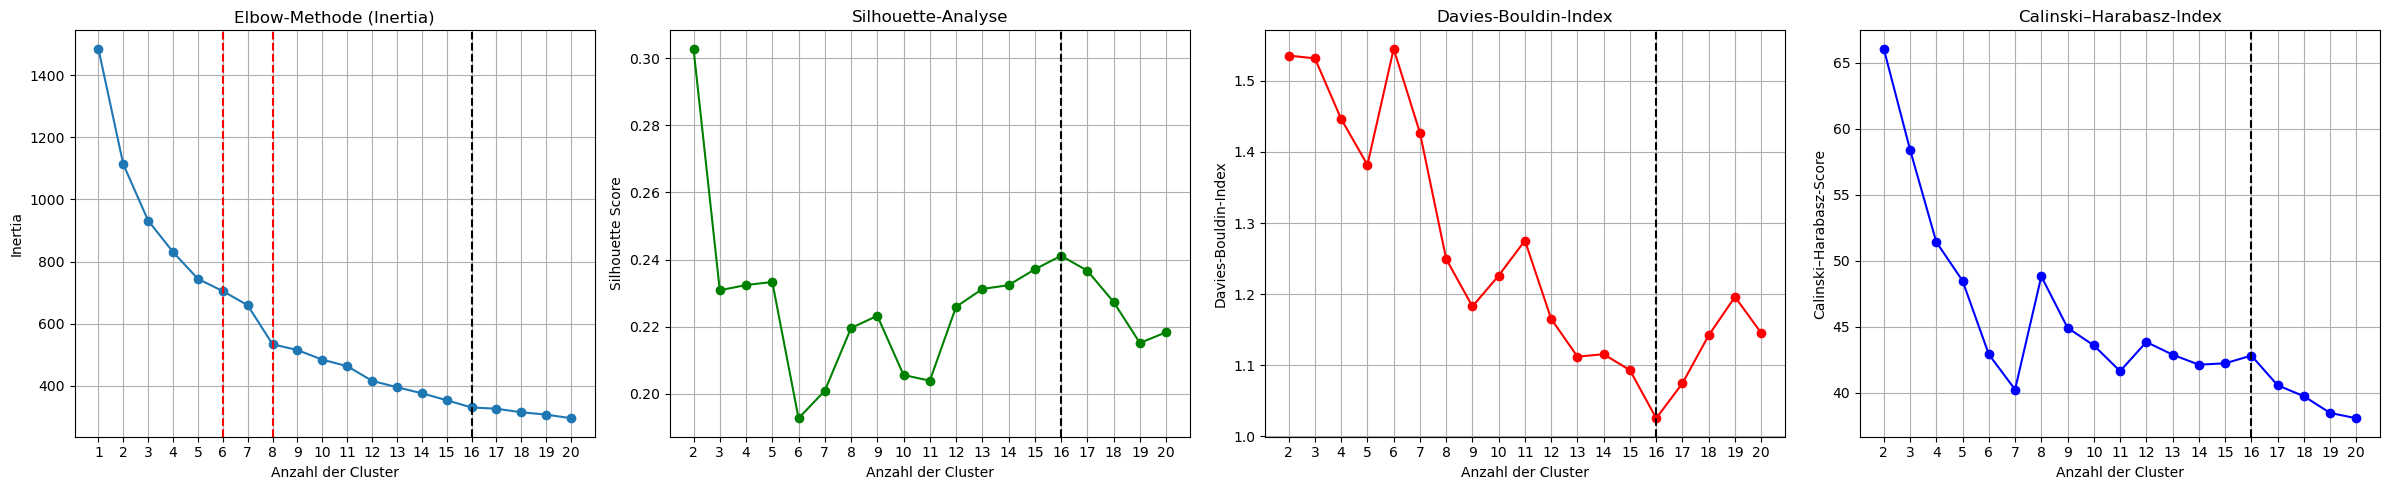

In [11]:


# Vorbereitung
inertia = []
silhouette_scores = []
db_scores = []
calinski_scores = []
cluster_range = range(1, 21)
cluster_range_eval = range(2, 21)  # Silhouette, DBI und Calinski erst ab 2 Clustern sinnvoll

# Berechnungen
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
    if k >= 2:
        labels = kmeans.labels_
        
        # Silhouette-Score
        silhouette_scores.append(silhouette_score(X, labels))
        
        # Davies-Bouldin-Index
        db_scores.append(davies_bouldin_score(X, labels))
        
        # Calinski–Harabasz-Index
        calinski_scores.append(calinski_harabasz_score(X, labels))

# Plotten nebeneinander (1×4)
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# 1. Elbow/Inertia
axes[0].plot(cluster_range, inertia, marker='o')
axes[0].axvline(x=6, color='red', linestyle='--')
axes[0].axvline(x=8, color='red', linestyle='--')
axes[0].axvline(x=16, color='black', linestyle='--')
axes[0].set_xlabel('Anzahl der Cluster')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow-Methode (Inertia)')
axes[0].grid(True)
axes[0].set_xticks(list(cluster_range))

# 2. Silhouette Score
axes[1].plot(cluster_range_eval, silhouette_scores, marker='o', color='green')
axes[1].axvline(x=16, color='black', linestyle='--')
axes[1].set_xlabel('Anzahl der Cluster')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette-Analyse')
axes[1].grid(True)
axes[1].set_xticks(list(cluster_range_eval))

# 3. Davies-Bouldin-Index
axes[2].plot(cluster_range_eval, db_scores, marker='o', color='red')
axes[2].axvline(x=16, color='black', linestyle='--')
axes[2].set_xlabel('Anzahl der Cluster')
axes[2].set_ylabel('Davies-Bouldin-Index')
axes[2].set_title('Davies-Bouldin-Index')
axes[2].grid(True)
axes[2].set_xticks(list(cluster_range_eval))

# 4. Calinski–Harabasz-Index
axes[3].plot(cluster_range_eval, calinski_scores, marker='o', color='blue')
axes[3].axvline(x=16, color='black', linestyle='--')
axes[3].set_xlabel('Anzahl der Cluster')
axes[3].set_ylabel('Calinski–Harabasz-Score')
axes[3].set_title('Calinski–Harabasz-Index')
axes[3].grid(True)
axes[3].set_xticks(list(cluster_range_eval))

plt.tight_layout()
plt.show()


Die Metriken verhalten sich teilweise instabil. Wenn die Daten Cluster unterschiedlicher Dichte, Form oder Größe enthalten, reagieren Metriken empfindlich auf die gewählte Clusteranzahl. Wenn sich Cluster teilweise überlappen oder Ausreißer enthalten sind, können die Metriken instabil werden, da sich die Clusterzentren stärker verschieben. In der Elbow Methode ist ein Knick zwischen 6 und 8 Clustern zu sehen. 

Visualisierung der Clusterlabel mittels PCA / t-SNE / UMAP

/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


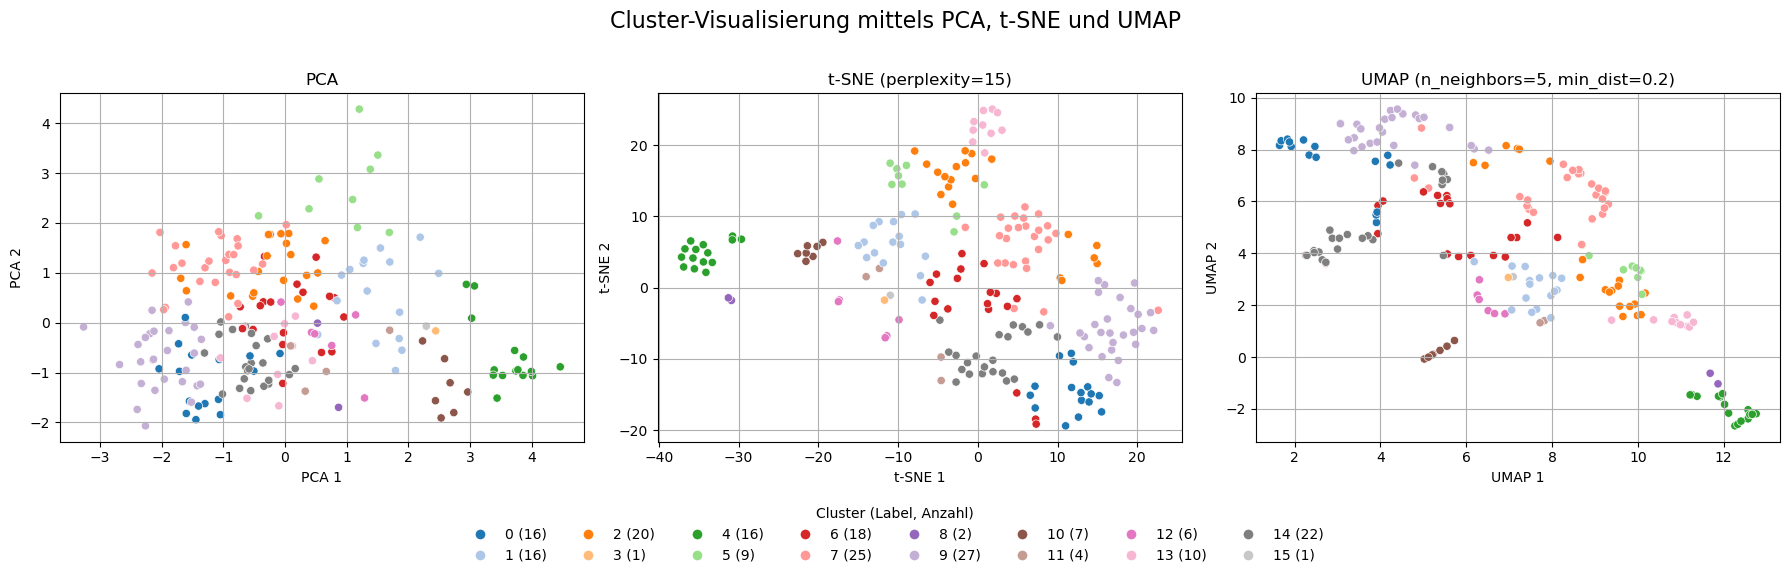

In [12]:
# Schritt 1: Numerische Daten extrahieren
X = df_scaled.select_dtypes(include='float64')

# Schritt 2: KMeans Clustering
n_clusters = 16  # ggf. anpassen
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
df_scaled['Cluster'] = kmeans.fit_predict(X)

# Schritt 3: Dimensionale Reduktionen
pca    = PCA(n_components=2)
X_pca  = pca.fit_transform(X)

tsne   = TSNE(n_components=2, random_state=0, perplexity=15)
X_tsne = tsne.fit_transform(X)

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,
    min_dist=0.2,
    metric='euclidean',
    random_state=42
)
X_umap = reducer.fit_transform(X)

# Tatsächlich verwendete Cluster-Anzahl
actual_n_clusters = df_scaled['Cluster'].nunique()

# Farbpalette dynamisch erzeugen
if actual_n_clusters <= 20:
    palette = sns.color_palette('tab20', n_colors=actual_n_clusters)
else:
    palette = sns.color_palette('hsv',    n_colors=actual_n_clusters)

# Schritt 4: Subplots nebeneinander
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_scaled['Cluster'],
    palette=palette,
    ax=axes[0],
    legend=False
)
axes[0].set_title('PCA')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].grid(True)

sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_scaled['Cluster'],
    palette=palette,
    ax=axes[1],
    legend=False
)
axes[1].set_title('t-SNE (perplexity=15)')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True)

sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=df_scaled['Cluster'],
    palette=palette,
    ax=axes[2],
    legend=False
)
axes[2].set_title('UMAP (n_neighbors=5, min_dist=0.2)')
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].grid(True)

fig.suptitle('Cluster-Visualisierung mittels PCA, t-SNE und UMAP', fontsize=16)

# Schritt 5: Punktzahlen pro Cluster ermitteln
counts = df_scaled['Cluster'].value_counts().to_dict()
# Sicherstellen, dass alle Cluster 0..actual_n_clusters-1 einen Eintrag haben
for i in range(actual_n_clusters):
    counts.setdefault(i, 0)

# Schritt 6: Legendeneinträge mit Anzahl ergänzen
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=palette[i], markersize=8)
    for i in range(actual_n_clusters)
]
legend_labels = [
    f"{i} ({counts[i]})" for i in range(actual_n_clusters)
]

fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='lower center',
    ncol=min(actual_n_clusters, 8),
    frameon=False,
    title='Cluster (Label, Anzahl)',
    bbox_to_anchor=(0.5, -0.15)
)

# Schritt 7: Layout so anpassen, dass Platz für die Legende bleibt
plt.tight_layout(rect=[0, 0.0, 1, 0.96])
plt.show()


Visualisierung der k-Means Label für 8, 12, 16 Cluster mittels UMAP

/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


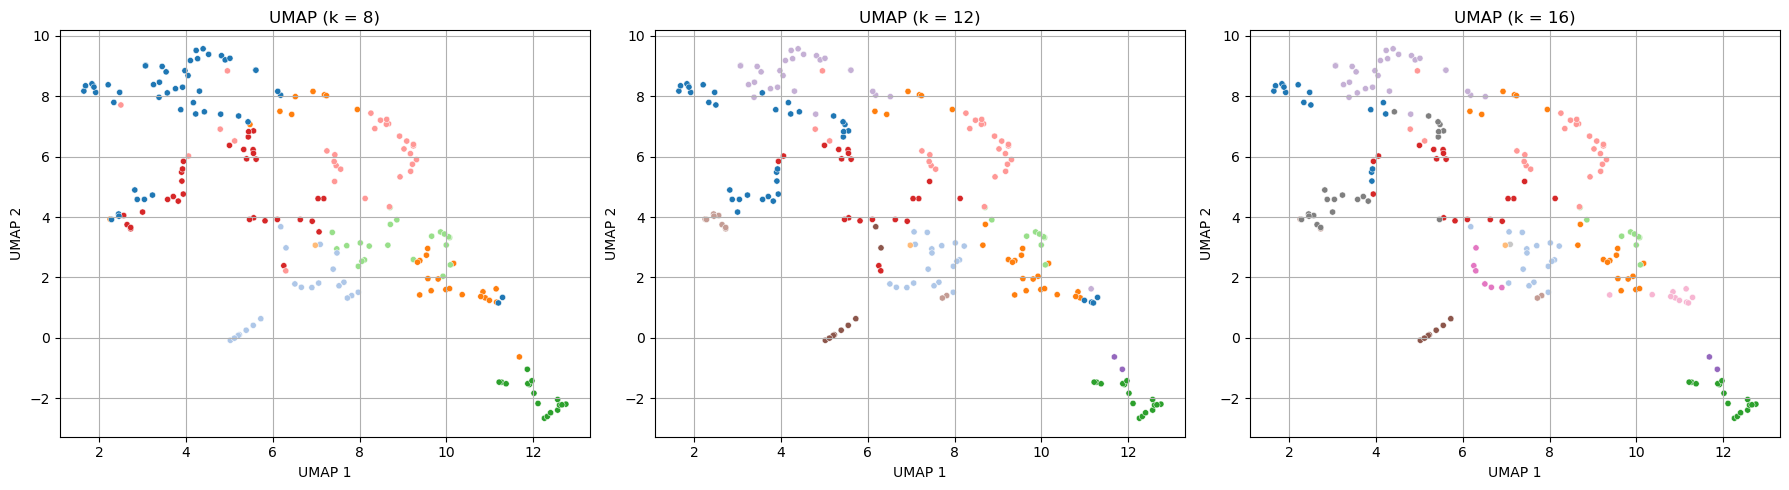

In [13]:
# Schritt 1: Numerische Daten extrahieren (gleiche X wie vorher verwenden)
X = df_scaled.select_dtypes(include='float64')

# Liste der gewünschten Cluster-Anzahlen
cluster_counts = [8, 12, 16]

# UMAP-Reduktion einmal außerhalb der Schleife berechnen,
# damit alle drei Plots auf derselben Einbettung basieren.
# (Falls du für jede Cluster-Anzahl eine eigene UMAP möchtest,
# verschiebe die folgenden drei Zeilen in die Schleife.)
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,
    min_dist=0.2,
    metric='euclidean',
    random_state=42
)
X_umap = reducer.fit_transform(X)

# Subplots nebeneinander (1×3)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, k in zip(axes, cluster_counts):
    # KMeans-Clustering für k
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(X)

    # Palette dynamisch erzeugen (bis zu 20 Farben mit 'tab20')
    if k <= 20:
        palette = sns.color_palette('tab20', n_colors=k)
    else:
        palette = sns.color_palette('hsv', n_colors=k)

    # UMAP-Scatterplot
    sns.scatterplot(
        x=X_umap[:, 0], 
        y=X_umap[:, 1],
        hue=labels,
        palette=palette,
        ax=ax,
        legend=False,        # Kein eingebettetes Legend (kann bei vielen Clustern unübersichtlich sein)
        s=20                 # Punktgröße anpassen, falls gewünscht
    )
    ax.set_title(f'UMAP (k = {k})')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(True)

plt.tight_layout()
plt.show()


#### Validierung

In [14]:
cluster_counts = df_scaled['Cluster'].value_counts().sort_index()
cluster_counts

Cluster
0     16
1     16
2     20
3      1
4     16
5      9
6     18
7     25
8      2
9     27
10     7
11     4
12     6
13    10
14    22
15     1
Name: count, dtype: int64

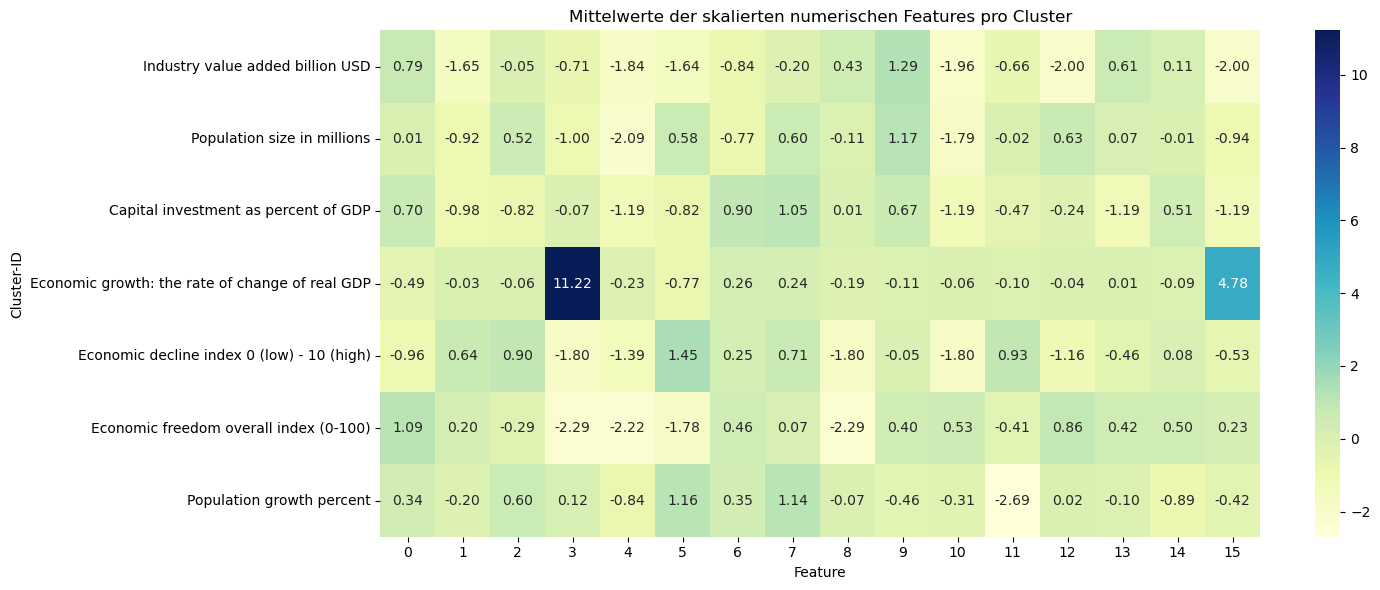

In [16]:
# Nur numerische Spalten als Features (ohne 'Cluster', falls Cluster numerisch ist, explizit rausnehmen!)
feature_cols = df_scaled.select_dtypes(include='number').columns
feature_cols = [col for col in feature_cols if col != 'Cluster']

# Mittelwerte je Cluster berechnen
cluster_means = df_scaled.groupby('Cluster')[feature_cols].mean()
cluster_means_T = cluster_means.T


# Heatmap plotten
plt.figure(figsize=(15, 6))
sns.heatmap(cluster_means_T, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Mittelwerte der skalierten numerischen Features pro Cluster")
plt.xlabel("Feature")
plt.ylabel("Cluster-ID")
plt.tight_layout()
plt.show()


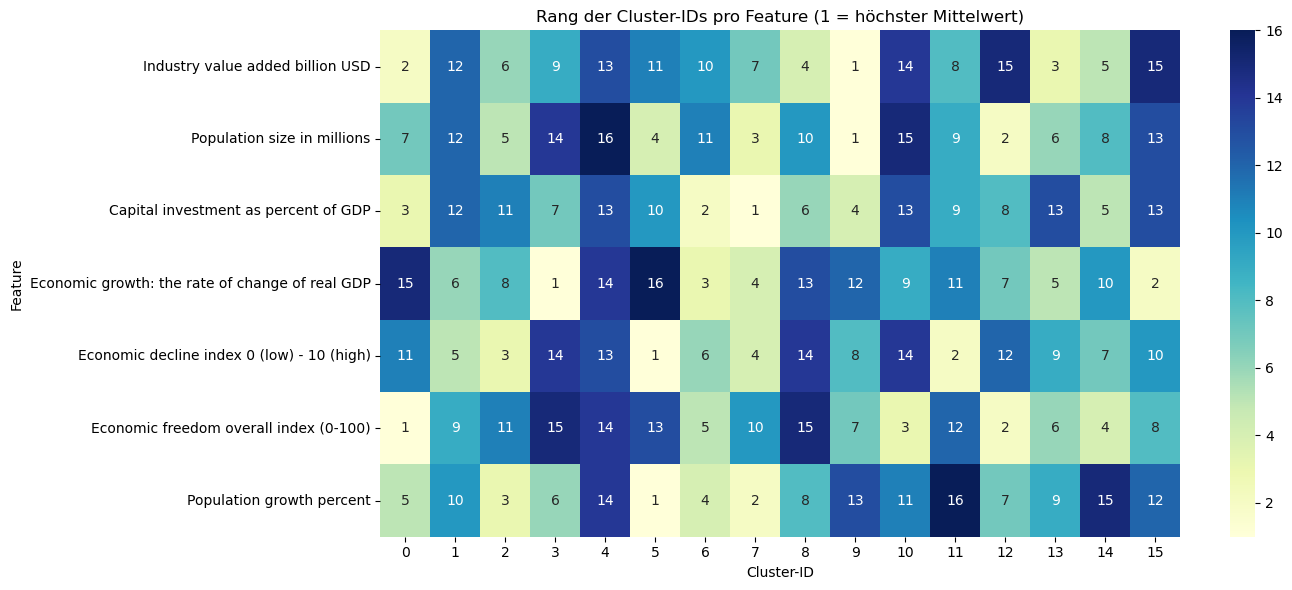

In [17]:
# Nur numerische Spalten als Features (ohne 'Cluster')
feature_cols = df_scaled.select_dtypes(include='number').columns
feature_cols = [col for col in feature_cols if col != 'Cluster']

# Mittelwerte je Cluster berechnen
cluster_means = df_scaled.groupby('Cluster')[feature_cols].mean()

# Rangmatrix berechnen (achse=1: pro Zeile, also pro Feature, .T macht's pro Feature)
cluster_ranks = cluster_means.T.rank(axis=1, method='min', ascending=False)


# Heatmap plotten
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_ranks, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title("Rang der Cluster-IDs pro Feature (1 = höchster Mittelwert)")
plt.xlabel("Cluster-ID")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [18]:
cluster_score = cluster_ranks.sum(axis=0)  # Summiere über Zeilen (axis=0) => ein Wert pro Cluster-ID
# cluster_score ist ein Series-Objekt mit Index = Cluster-ID und Wert = Summe der Ränge

# 2. Gesamt-Rang zuweisen (1 = beste Cluster-ID mit niedrigster Rang-Summe)
overall_rank = cluster_score.rank(method='min', ascending=True).astype(int)
# ascending=True: niedrigster Score bekommt Rang 1

# 3. Ergebnisse in einem DataFrame zusammenfassen
df_overall = pd.DataFrame({
    'Summe_Feature_Ranks': cluster_score,
    'Gesamt_Rang': overall_rank
}).sort_values(by='Gesamt_Rang')  # aufsteigend nach Gesamt_Rang sortieren

print("\nOverall-Ranking der Cluster:")
print(df_overall)



Overall-Ranking der Cluster:
         Summe_Feature_Ranks  Gesamt_Rang
Cluster                                  
7                       31.0            1
6                       41.0            2
0                       44.0            3
9                       46.0            4
2                       47.0            5
13                      51.0            6
12                      53.0            7
14                      54.0            8
5                       56.0            9
1                       66.0           10
3                       66.0           10
11                      67.0           12
8                       70.0           13
15                      73.0           14
10                      79.0           15
4                       97.0           16


In [19]:
countries_cluster7 = df_scaled.loc[df_scaled['Cluster'] == 7, 'Country']
countries_cluster7

188                               Algeria
313                                Angola
1261                                Benin
1829                         Burkina Faso
2903     Democratic Republic of the Congo
4675                             Honduras
5374                          Ivory Coast
5691                                Kenya
6570                           Madagascar
6823                                 Mali
7614                                Nepal
7932                                Niger
9071                Republic of the Congo
9259                               Rwanda
9700                              Senegal
10967                            Tanzania
11095                                Togo
11537                              Uganda
11918                          Uzbekistan
12332                            Cameroon
12338            Central African Republic
12340                                Chad
12429                            Ethiopia
12446                             

In [20]:
countries_cluster9 = df_scaled.loc[df_scaled['Cluster'] == 9, 'Country']
countries_cluster9

440           Argentina
945          Bangladesh
1639             Brazil
2397              Chile
2460              China
2524           Colombia
3820             France
4991          Indonesia
5310              Italy
6697           Malaysia
7076             Mexico
7424            Morocco
8755        Philippines
8818             Poland
9134            Romania
10267      South Africa
10331       South Korea
10395             Spain
11031          Thailand
11349            Turkey
11727    United Kingdom
12439           Germany
12463             India
12467              Iran
12541              Peru
12551            Russia
12556      Saudi Arabia
Name: Country, dtype: category
Categories (202, object): ['Afghanistan', 'Albania', 'Algeria', 'Andorra', ..., 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']

/tmp/ipykernel_321612/982113330.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_scaled.pivot_table(


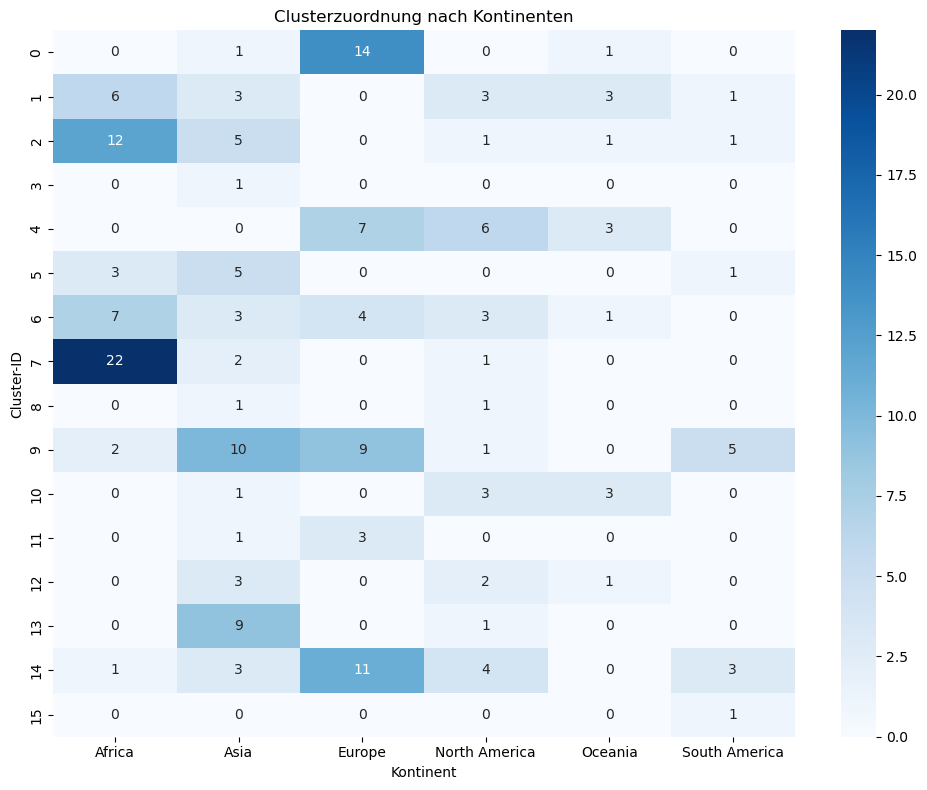

In [21]:
# Pivot-Tabelle: Anzahl pro Cluster und Kontinent
pivot = df_scaled.pivot_table(
    index='Cluster',
    columns='Continent',
    aggfunc='size',
    fill_value=0
)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title("Clusterzuordnung nach Kontinenten")
plt.xlabel("Kontinent")
plt.ylabel("Cluster-ID")
plt.tight_layout()
plt.show()


## Hierarchisches Clustern 

/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


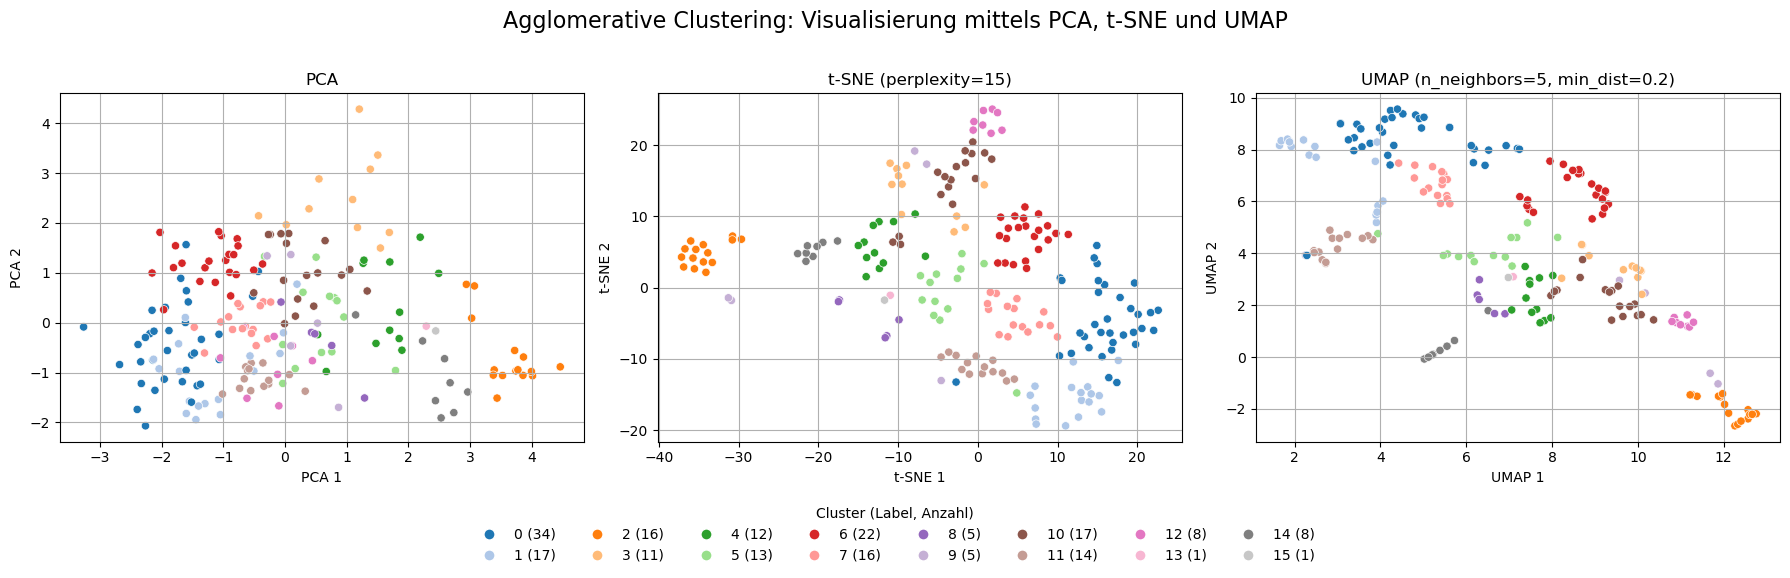

In [22]:

# Schritt 1: Numerische Daten extrahieren
X = df_scaled.select_dtypes(include='float64')

# Schritt 2: Agglomerative Clustering
n_clusters = 16  # Anzahl der Cluster einstellen
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_scaled['Cluster'] = agglo.fit_predict(X)

# Schritt 3: Dimensionale Reduktionen
# ----------------------------------
# PCA
pca    = PCA(n_components=2)
X_pca  = pca.fit_transform(X)

# t-SNE mit Perplexity = 15
tsne   = TSNE(n_components=2, random_state=0, perplexity=15)
X_tsne = tsne.fit_transform(X)

# UMAP mit n_neighbors=5, min_dist=0.2
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,
    min_dist=0.2,
    metric='euclidean',
    random_state=42
)
X_umap = reducer.fit_transform(X)

# Tatsächlich verwendete Cluster-Anzahl (falls Abweichung)
actual_n_clusters = df_scaled['Cluster'].nunique()

# Schritt 4: Dynamische Farbpalette erzeugen
# ------------------------------------------
# Für bis zu 20 Cluster: 'tab20', sonst 'hsv'
if actual_n_clusters <= 20:
    palette = sns.color_palette('tab20', n_colors=actual_n_clusters)
else:
    palette = sns.color_palette('hsv',    n_colors=actual_n_clusters)

# Schritt 5: Subplots nebeneinander
# ----------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA-Plot (ohne Legende pro Achse)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_scaled['Cluster'],
    palette=palette,
    ax=axes[0],
    legend=False
)
axes[0].set_title('PCA')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].grid(True)

# t-SNE-Plot (ohne Legende pro Achse)
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_scaled['Cluster'],
    palette=palette,
    ax=axes[1],
    legend=False
)
axes[1].set_title('t-SNE (perplexity=15)')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True)

# UMAP-Plot (ohne Legende pro Achse)
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=df_scaled['Cluster'],
    palette=palette,
    ax=axes[2],
    legend=False
)
axes[2].set_title('UMAP (n_neighbors=5, min_dist=0.2)')
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].grid(True)

fig.suptitle('Agglomerative Clustering: Visualisierung mittels PCA, t-SNE und UMAP', fontsize=16)

# Schritt 6: Punktzahlen pro Cluster ermitteln
# --------------------------------------------
counts = df_scaled['Cluster'].value_counts().to_dict()
for i in range(actual_n_clusters):
    counts.setdefault(i, 0)

# Schritt 7: Gemeinsame Legende unter den Subplots einfügen
# ---------------------------------------------------------
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=palette[i], markersize=8)
    for i in range(actual_n_clusters)
]
legend_labels = [
    f"{i} ({counts[i]})" for i in range(actual_n_clusters)
]

fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='lower center',
    ncol=min(actual_n_clusters, 8),
    frameon=False,
    title='Cluster (Label, Anzahl)',
    bbox_to_anchor=(0.5, -0.15)
)

# Schritt 8: Layout so anpassen, dass Platz für die Legende bleibt
# -----------------------------------------------------------------
plt.tight_layout(rect=[0, 0.0, 1, 0.96])
plt.show()


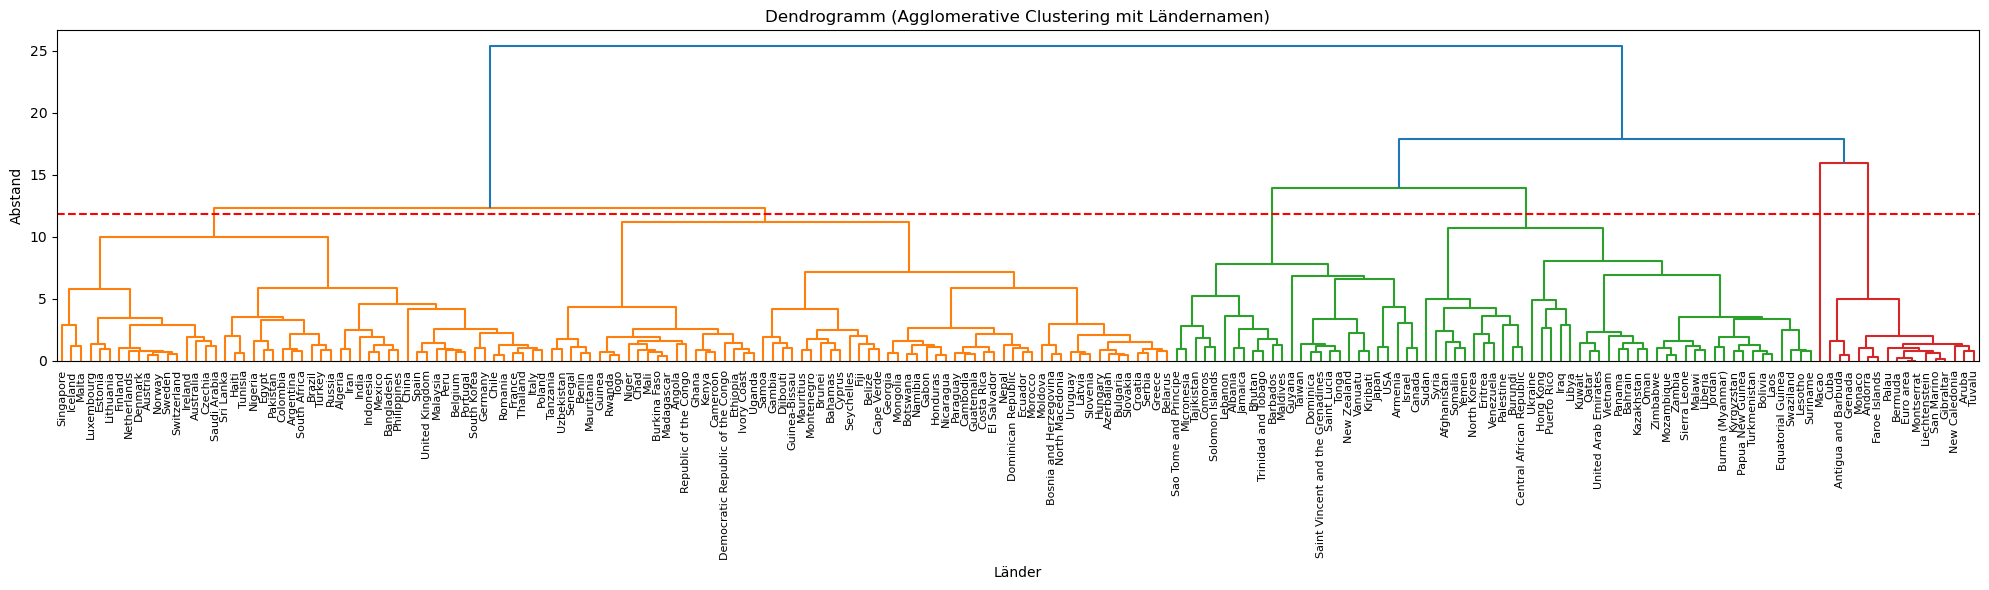

In [23]:

# Schritt 1: Datenmatrix und Labels vorbereiten
X = df_scaled.select_dtypes(include='float64').copy()
labels = df_scaled['Country'].tolist()

# Schritt 2: Linkage-Matrix berechnen (Ward-Methode)
linked = linkage(X, method='ward')

# Schritt 3: Dendrogramm mit Ländernamen anzeigen
plt.figure(figsize=(20, 6))
dendrogram(
    linked,
    labels=labels,           # Länder als X-Achse
    leaf_rotation=90,        # besser lesbar
    leaf_font_size=8        # kleinere Schrift
)
plt.axhline(y=11.8, color='red', linestyle='--', linewidth=1.5)
plt.title('Dendrogramm (Agglomerative Clustering mit Ländernamen)')
plt.xlabel('Länder')
plt.ylabel('Abstand')
plt.tight_layout()
plt.show()


In [24]:

np.random.seed(0)
df_scaled_2 = pd.DataFrame(np.random.rand(100, 5), columns=[f'feature_{i}' for i in range(5)])

# Numerische Daten
X = df_scaled_2.select_dtypes(include='float64')

# Cluster-Anzahl als Variable definieren
n_clusters = 6

# KMEANS
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
df_scaled_2['Cluster_KMeans'] = kmeans.fit_predict(X)

# AGGLOMERATIVE
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_scaled_2['Cluster_Agglo'] = agglo.fit_predict(X)

# Metriken berechnen
def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels)
    }

metrics_kmeans = evaluate_clustering(X, df_scaled_2['Cluster_KMeans'])
metrics_agglo = evaluate_clustering(X, df_scaled_2['Cluster_Agglo'])

# Ausgabe als DataFrame
metrics_df = pd.DataFrame([metrics_kmeans, metrics_agglo], index=["KMeans", "Agglomerative"])
metrics_df


Silhouette  Calinski-Harabasz  Davies-Bouldin
KMeans           0.189278          20.592636        1.464388
Agglomerative    0.174897          18.181454        1.291112

/tmp/ipykernel_321612/4102054832.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', n_clusters)


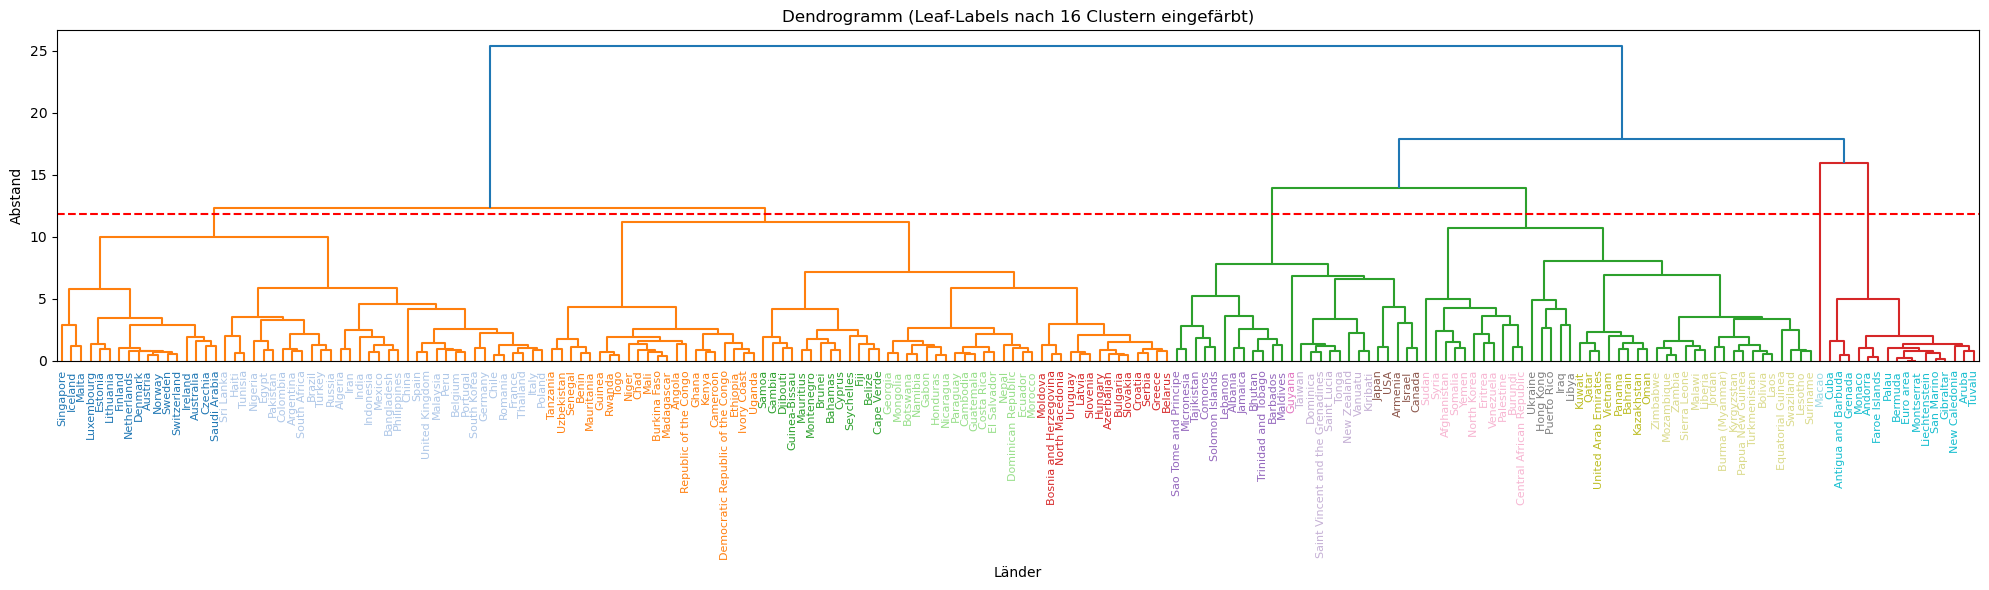

In [25]:


# ---------------------------
# 1. Linkage-Matrix berechnen
# ---------------------------

# Beispiel: df_scaled enthält numerische Spalten plus eine Spalte 'Country' mit Länder‐Namen
X = df_scaled.select_dtypes(include='float64').copy().values
labels = df_scaled['Country'].tolist()

# Agglomerative Clustering (Ward) – erzeugt die Linkage-Matrix
linked = linkage(X, method='ward')

# ---------------------------
# 2. Cluster-Anzahl als Variable
# ---------------------------
n_clusters = 16  # Hier kannst du die gewünschte Cluster-Anzahl einstellen

# Flache Cluster (maxclust = n_clusters) ermitteln
# fcluster liefert für jeden Datenpunkt (Land) eine Cluster‐ID zwischen 1 und n_clusters
cluster_assignments = fcluster(linked, t=n_clusters, criterion='maxclust')

# Erstelle ein Dictionary {Country: cluster_id}
cluster_dict = dict(zip(labels, cluster_assignments))

# ------------------------------------------------------
# 3. Dendrogramm plotten und Blatt‐Labels nach Cluster färben
# ------------------------------------------------------

plt.figure(figsize=(20, 6))
ddata = dendrogram(
    linked,
    labels=labels,           # Länder als X-Achse
    leaf_rotation=90,        # Labels senkrecht
    leaf_font_size=8,        # Schriftgröße
    color_threshold=None     # Damit die Branch‐Färbung nicht automatisch erfolgt
)

# Rote Linie bei y=11.8 einzeichnen (oder passe den Wert an, falls nötig)
plt.axhline(y=11.8, color='red', linestyle='--', linewidth=1.5)

# Jetzt holen wir uns die aktuelle Achse, um auf die xticklabels zugreifen zu können
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()

# Eine Farbliste aussuchen (hier z.B. das 'tab10'-Colormap von Matplotlib)
# Nun mit n_clusters unterschiedliche Farben bereitstellen
colormap = cm.get_cmap('tab20', n_clusters)

# Jeden Tick-Label einfärben je nach zugeordnetem Cluster
for lbl in x_labels:
    country_name = lbl.get_text()
    cluster_id = cluster_dict[country_name]  # 1 bis n_clusters
    # colormap liefert RGBA, indexiere aber mit cluster_id-1 (0-basiert)
    lbl.set_color(colormap(cluster_id - 1))

# Achsentitel / Layout
plt.title(f'Dendrogramm (Leaf-Labels nach {n_clusters} Clustern eingefärbt)')
plt.xlabel('Länder')
plt.ylabel('Abstand')
plt.tight_layout()
plt.show()


## Vergleich zweier Clusterergebnisse 

### Hungarian Matching (Label-Alignment) K-Means & AgglomerativeClustering

/tmp/ipykernel_321612/1512895432.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', n_clusters)


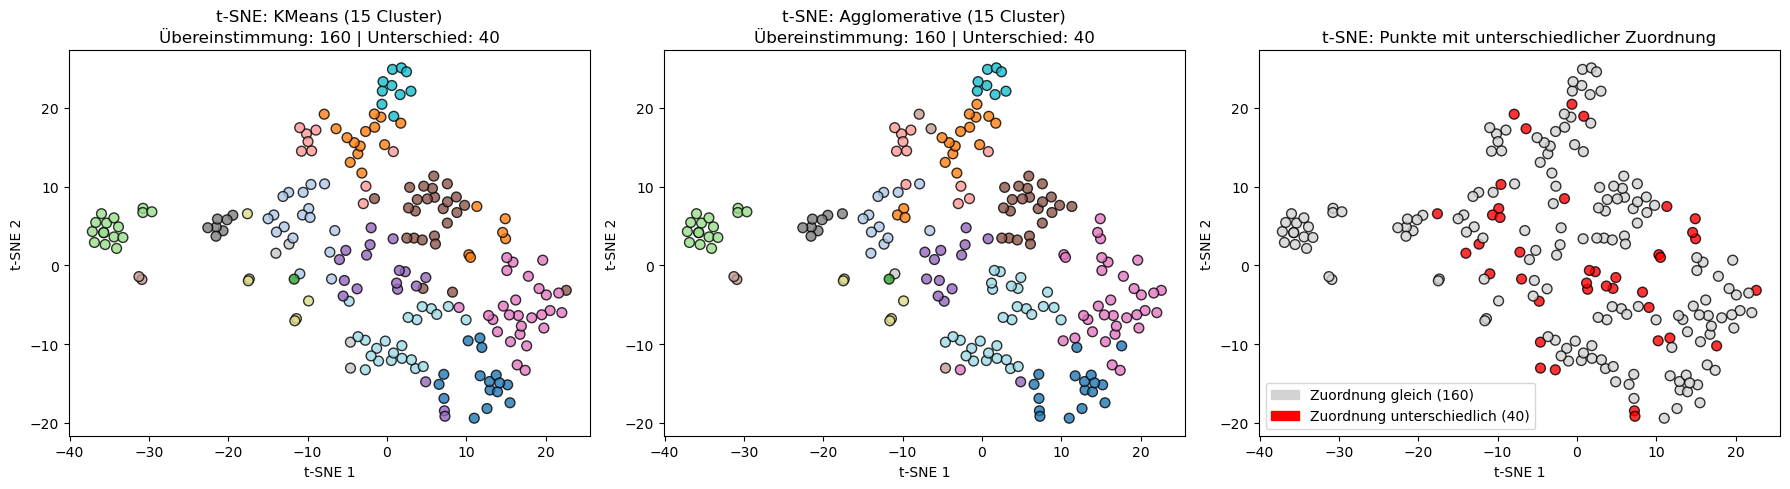

In [26]:


# --- 1. Numerische Daten extrahieren ---
X = df_scaled.select_dtypes(include='float64').values

# --- 2. Cluster-Anzahl als Variable ---
n_clusters = 15  # Hier kannst du die gewünschte Cluster-Anzahl einstellen

# --- 3. Zwei Clusterings berechnen ---
# 3.1 KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# 3.2 AgglomerativeClustering (Ward)
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_agglo = agglo.fit_predict(X)

# --- 4. Labels von Agglo an KMeans anpassen (Hungarian Matching) ---
cont_mat = contingency_matrix(labels_kmeans, labels_agglo)
cost_matrix = -cont_mat
row_ind, col_ind = linear_sum_assignment(cost_matrix)
mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
labels_agglo_aligned = np.vectorize(lambda x: mapping[x])(labels_agglo)

# --- 5. „Streitende“ Punkte identifizieren ---
disagree = (labels_kmeans != labels_agglo_aligned)  # Bool-Array: True = unterschiedliche Zuordnung
count_disagree = np.sum(disagree)
count_agree = X.shape[0] - count_disagree

# --- 6. t-SNE auf die Daten anwenden (n_components=2, Perplexity=15) ---
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
X_tsne = tsne.fit_transform(X)

# --- 7. Subplots erzeugen: KMeans, Agglomerative, Streitende Punkte ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dynamische Farbauswahl: bei ≤10 Clustern 'tab10', ≤20 'tab20', sonst 'hsv'
if n_clusters <= 10:
    cmap = cm.get_cmap('tab10', n_clusters)
elif n_clusters <= 20:
    cmap = cm.get_cmap('tab20', n_clusters)
else:
    cmap = cm.get_cmap('hsv', n_clusters)

# 7.1 KMeans-Plot
axes[0].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=labels_kmeans,
    cmap=cmap,
    edgecolors='k',
    s=50,
    alpha=0.8
)
axes[0].set_title(f't-SNE: KMeans ({n_clusters} Cluster)\nÜbereinstimmung: {count_agree} | Unterschied: {count_disagree}')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

# 7.2 AgglomerativeClustering-Plot
axes[1].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=labels_agglo_aligned,
    cmap=cmap,
    edgecolors='k',
    s=50,
    alpha=0.8
)
axes[1].set_title(f't-SNE: Agglomerative ({n_clusters} Cluster)\nÜbereinstimmung: {count_agree} | Unterschied: {count_disagree}')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

# 7.3 Streitende Punkte-Plot
colors = np.where(disagree, 'red', 'lightgray')
axes[2].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=colors,
    edgecolors='k',
    s=50,
    alpha=0.8
)
axes[2].set_title('t-SNE: Punkte mit unterschiedlicher Zuordnung')
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')

# 7.4 Manuelle Legende für den rechten Plot (Streitende Punkte) mit Zählung
patch_agree = mpatches.Patch(color='lightgray', label=f'Zuordnung gleich ({count_agree})')
patch_disagree = mpatches.Patch(color='red',       label=f'Zuordnung unterschiedlich ({count_disagree})')
axes[2].legend(handles=[patch_agree, patch_disagree], loc='lower left')

plt.tight_layout()
plt.show()


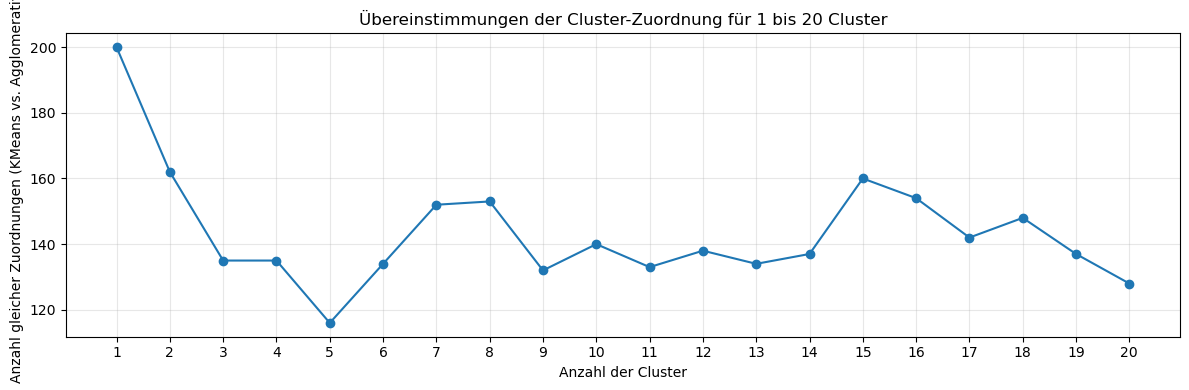

In [27]:
# --- 1. Numerische Daten extrahieren ---
X = df_scaled.select_dtypes(include='float64').values

# --- 2. Listen für Ergebnisse vorbereiten ---
cluster_range = range(1, 21)  # 1 bis 20
agreements = []              # hier speichern wir count_agree für jede Clusterzahl

# --- 3. Schleife über Clusterzahlen ---
for n_clusters in cluster_range:
    # 3.1 KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels_kmeans = kmeans.fit_predict(X)

    # 3.2 AgglomerativeClustering (Ward)
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels_agglo = agglo.fit_predict(X)

    # --- 4. Labels von Agglo an KMeans anpassen (Hungarian Matching) ---
    cont_mat = contingency_matrix(labels_kmeans, labels_agglo)
    cost_matrix = -cont_mat
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    labels_agglo_aligned = np.vectorize(lambda x: mapping[x])(labels_agglo)

    # --- 5. „Streitende“ Punkte identifizieren und zählen ---
    disagree = (labels_kmeans != labels_agglo_aligned)
    count_disagree = np.sum(disagree)
    count_agree = X.shape[0] - count_disagree

    # Ergebnis speichern
    agreements.append(count_agree)

# --- 6. Plot: Clusterzahl vs. Anzahl gleicher Zuordnungen ---
plt.figure(figsize=(12, 4))
plt.plot(list(cluster_range), agreements, marker='o', linestyle='-')
plt.xticks(list(cluster_range))
plt.xlabel('Anzahl der Cluster')
plt.ylabel('Anzahl gleicher Zuordnungen (KMeans vs. Agglomerativ)')
plt.title('Übereinstimmungen der Cluster-Zuordnung für 1 bis 20 Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


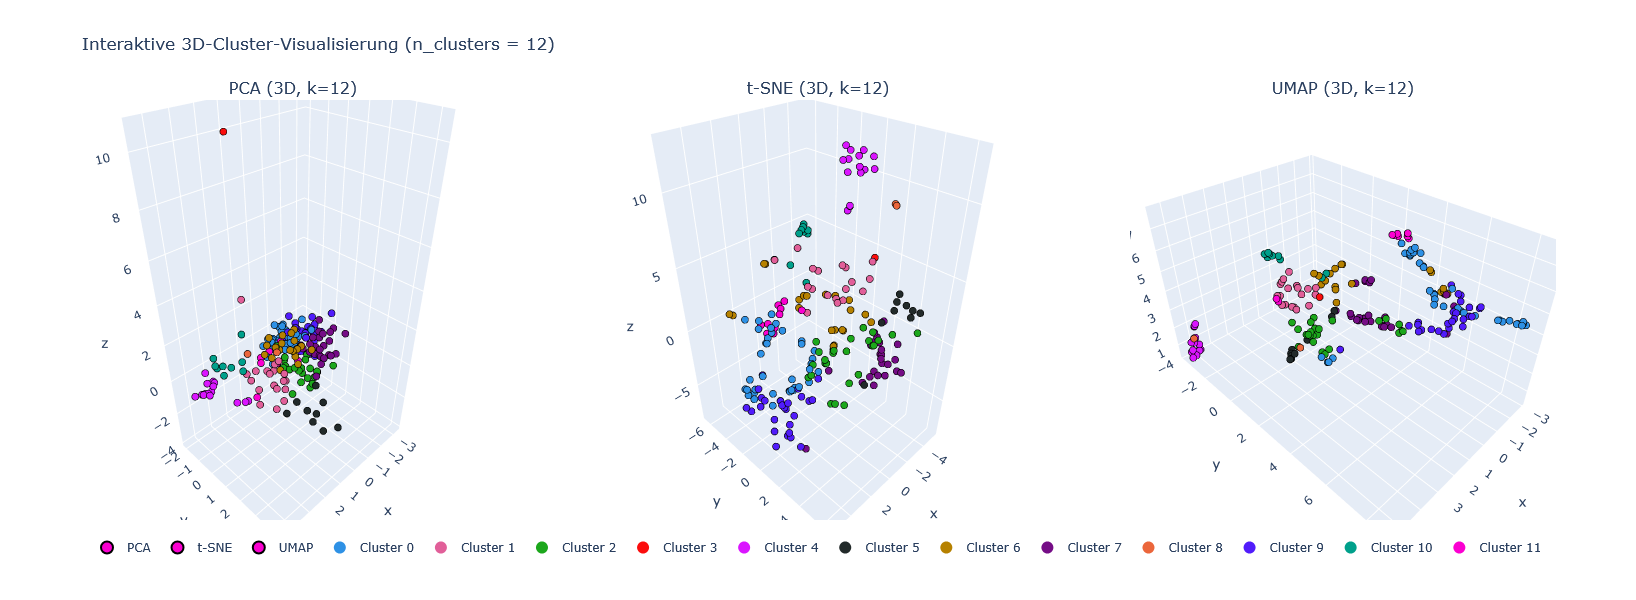

In [28]:
# --- 1. Numerische Daten extrahieren ---
X = df_scaled.select_dtypes(include='float64')

# --- 2. Cluster-Anzahl als Variable ---
n_clusters = 12  # Beispiel: mehr als 10

# --- 3. KMeans Clustering ---
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
df_scaled['Cluster'] = kmeans.fit_predict(X)

# --- 4. Dimensionale Reduktionen (3D) ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=3, random_state=0, perplexity=15)
X_tsne = tsne.fit_transform(X)

reducer = umap.UMAP(
    n_components=3,
    n_neighbors=5,
    min_dist=0.2,
    metric='euclidean',
    random_state=42
)
X_umap = reducer.fit_transform(X)

# --- 5. Diskrete Farbpalette für beliebig viele Cluster ---
# Wir verwenden eine Plotly-Express-Palette mit genug Farben, z. B. Dark24 oder Prism
qual_palette = px.colors.qualitative.Dark24  # 24 Farben
# Falls n_clusters > len(qual_palette), rotieren wir einfach in der Palette
palette = [qual_palette[i % len(qual_palette)] for i in range(n_clusters)]

# Pro Punkt eine Farbe zuweisen (hier nach Cluster-Index)
point_colors = [palette[label] for label in df_scaled['Cluster']]

# Hover-Text
hover_texts = [f'Cluster {i}' for i in df_scaled['Cluster']]

# --- 6. Interaktive 3D-Subplots erstellen ---
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=(f'PCA (3D, k={n_clusters})',
                    f't-SNE (3D, k={n_clusters})',
                    f'UMAP (3D, k={n_clusters})')
)

# PCA-Plot
fig.add_trace(
    go.Scatter3d(
        x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=point_colors,   # aus diskreter Palette
            line=dict(width=0.2, color='black')
        ),
        text=hover_texts,
        name='PCA'
    ), row=1, col=1
)

# t-SNE-Plot
fig.add_trace(
    go.Scatter3d(
        x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=point_colors,
            line=dict(width=0.2, color='black')
        ),
        text=hover_texts,
        name='t-SNE'
    ), row=1, col=2
)

# UMAP-Plot
fig.add_trace(
    go.Scatter3d(
        x=X_umap[:, 0], y=X_umap[:, 1], z=X_umap[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=point_colors,
            line=dict(width=0.2, color='black')
        ),
        text=hover_texts,
        name='UMAP'
    ), row=1, col=3
)

# --- 7. Gemeinsame Legende erstellen ---
# Wir erzeugen einzelne Dummy-Traces für die Legende, je Cluster eine Farbe
legend_handles = []
for idx in range(n_clusters):
    legend_handles.append(
        go.Scatter3d(
            x=[None], y=[None], z=[None],
            mode='markers',
            marker=dict(size=6, color=palette[idx]),
            showlegend=True,
            name=f'Cluster {idx}'
        )
    )
# Legenden-Traces hinzufügen (unsichtbar im Plot selbst)
for lh in legend_handles:
    fig.add_trace(lh, row=1, col=1)

# Layout anpassen
fig.update_layout(
    height=600,
    width=1800,
    title_text=f'Interaktive 3D-Cluster-Visualisierung (n_clusters = {n_clusters})',
    legend=dict(
        itemsizing='constant',
        orientation='h',
        yanchor='bottom',
        y=-0.1,
        xanchor='center',
        x=0.5
    )
)

fig.show()


## DB-Scan

In [29]:

X = df_scaled.select_dtypes(include='float64')

In [30]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
X_tsne = tsne.fit_transform(X)

Gridsearch Parameterraum

In [31]:
param_grid = {
    'eps': np.arange(0.1, 6.1, 0.1),
    'min_samples': np.arange(3, 51, 1),
}
param_grid

{'eps': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
        2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
        4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
        5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ]),
 'min_samples': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}


Beste Parameterkombination (min. DBI, max. CHI):
eps: 1.1, min_samples: 3.0
Anzahl Cluster: 5.0
Noise-Anteil: 28.50%
Davies–Bouldin: 2.100
Calinski–Harabasz: 16.1


/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



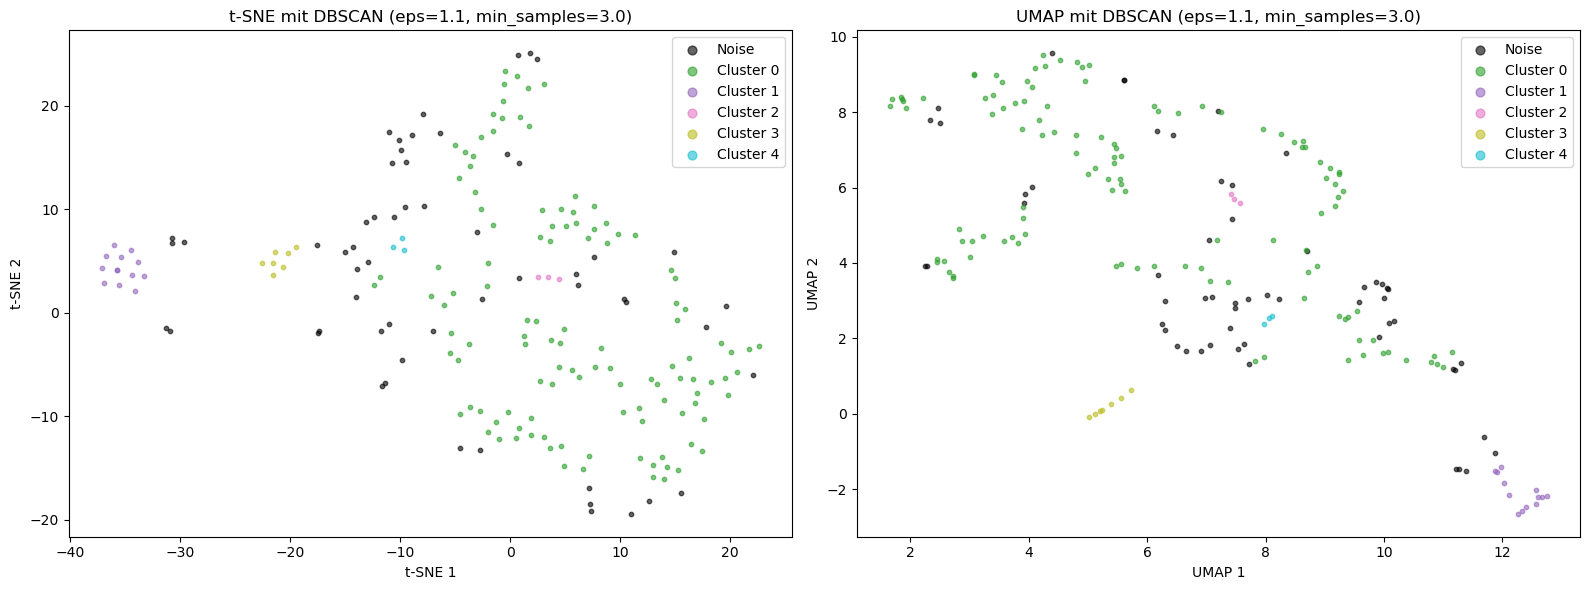

In [32]:

grid_data = []
for params in ParameterGrid(param_grid):
    # Stelle sicher, dass min_samples als int übergeben wird:
    eps_val = params['eps']
    min_samp = int(params['min_samples'])
    
    db = DBSCAN(eps=eps_val, min_samples=min_samp, metric='euclidean')  # Metrik nach Bedarf anpassen
    labels = db.fit_predict(X)

    # Anzahl der Cluster (ohne Noise):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Noise-Anteil:
    noise_count = Counter(labels).get(-1, 0)
    noise_ratio = noise_count / len(labels)

    # Filter: mindestens 5 Cluster, maximal 50 % Noise
    if n_clusters < 5 or noise_ratio > 0.50:
        continue

    # Nur wenn ≥ 2 Cluster vorhanden sind, berechnen wir DBI und CHI
    if n_clusters >= 2:
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)
    else:
        dbi = np.nan
        chi = np.nan

    grid_data.append({
        'eps': eps_val,
        'min_samples': min_samp,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'davies_bouldin': dbi,
        'calinski_harabasz': chi
    })

if not grid_data:
    print("Keine Parameterkombination mit ≥ 5 Clustern und ≤ 50 % Noise gefunden.")
else:
    df = pd.DataFrame(grid_data)
    # Sortiere: 1) DBI klein (ascending), 2) CHI groß (descending)
    df_sorted = df.sort_values(
        by=['davies_bouldin', 'calinski_harabasz'],
        ascending=[True, False]
    )
    best = df_sorted.iloc[0]
    print("\nBeste Parameterkombination (min. DBI, max. CHI):")
    print(f"eps: {best['eps']}, min_samples: {best['min_samples']}")
    print(f"Anzahl Cluster: {best['n_clusters']}")
    print(f"Noise-Anteil: {best['noise_ratio']:.2%}")
    print(f"Davies–Bouldin: {best['davies_bouldin']:.3f}")
    print(f"Calinski–Harabasz: {best['calinski_harabasz']:.1f}")

    # Führe DBSCAN mit den besten Parametern noch einmal aus, um best_labels zu erhalten
    best_db = DBSCAN(
        eps=best['eps'],
        min_samples=int(best['min_samples']),
        metric='euclidean'
    )
    best_labels = best_db.fit_predict(X)

    # ——————————————————————————————————————————————————————————————
    # 2. UMAP-Embedding berechnen
    # ——————————————————————————————————————————————————————————————
    umap_model = umap.UMAP(
        n_components=2,
        n_neighbors=5,
        min_dist=0.2,
        metric='euclidean',
        random_state=42
    )
    X_umap = umap_model.fit_transform(X)

    # ——————————————————————————————————————————————————————————————
    # 3. Zusammengefasster Plot mit 2 Subplots: t-SNE und UMAP
    # ——————————————————————————————————————————————————————————————

    unique_labels = sorted(set(best_labels))
    n_clusters = best['n_clusters']

    # Colormap: tab10 für ≤10 Cluster, sonst tab20
    cmap = plt.get_cmap("tab10") if n_clusters <= 10 else plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}
    color_dict[-1] = (0, 0, 0)  # Noise (Label = -1) in schwarz

    # Erstelle 1×2 Subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 3.1 t-SNE-Plot (linker Subplot)
    ax_tsne = axes[0]
    for label in unique_labels:
        mask = (best_labels == label)
        ax_tsne.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            c=[color_dict[label]],
            label=f'Cluster {label}' if label != -1 else 'Noise',
            alpha=0.6,
            s=10
        )
    ax_tsne.set_title(f't-SNE mit DBSCAN (eps={best["eps"]}, min_samples={best["min_samples"]})')
    ax_tsne.set_xlabel('t-SNE 1')
    ax_tsne.set_ylabel('t-SNE 2')
    ax_tsne.legend(loc='best', markerscale=2)

    # 3.2 UMAP-Plot (rechter Subplot)
    ax_umap = axes[1]
    for label in unique_labels:
        mask = (best_labels == label)
        ax_umap.scatter(
            X_umap[mask, 0], X_umap[mask, 1],
            c=[color_dict[label]],
            label=f'Cluster {label}' if label != -1 else 'Noise',
            alpha=0.6,
            s=10
        )
    ax_umap.set_title(f'UMAP mit DBSCAN (eps={best["eps"]}, min_samples={best["min_samples"]})')
    ax_umap.set_xlabel('UMAP 1')
    ax_umap.set_ylabel('UMAP 2')
    # Damit die Legende nicht doppelt erscheint, kannst Du sie nur im ersten Plot anzeigen
    # oder Du kommentierst das folgende aus, wenn Du es im UMAP-Plot weglassen willst:
    ax_umap.legend(loc='best', markerscale=2)

    plt.tight_layout()
    plt.show()


## HDB-Scan

/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Beste Parameterkombination für HDBSCAN (min. DBI, max. CHI):
min_cluster_size: 2, min_samples: 2
Anzahl Cluster: 5
Noise-Anteil: 11.00%
Davies–Bouldin: 2.066
Calinski–Harabasz: 13.8


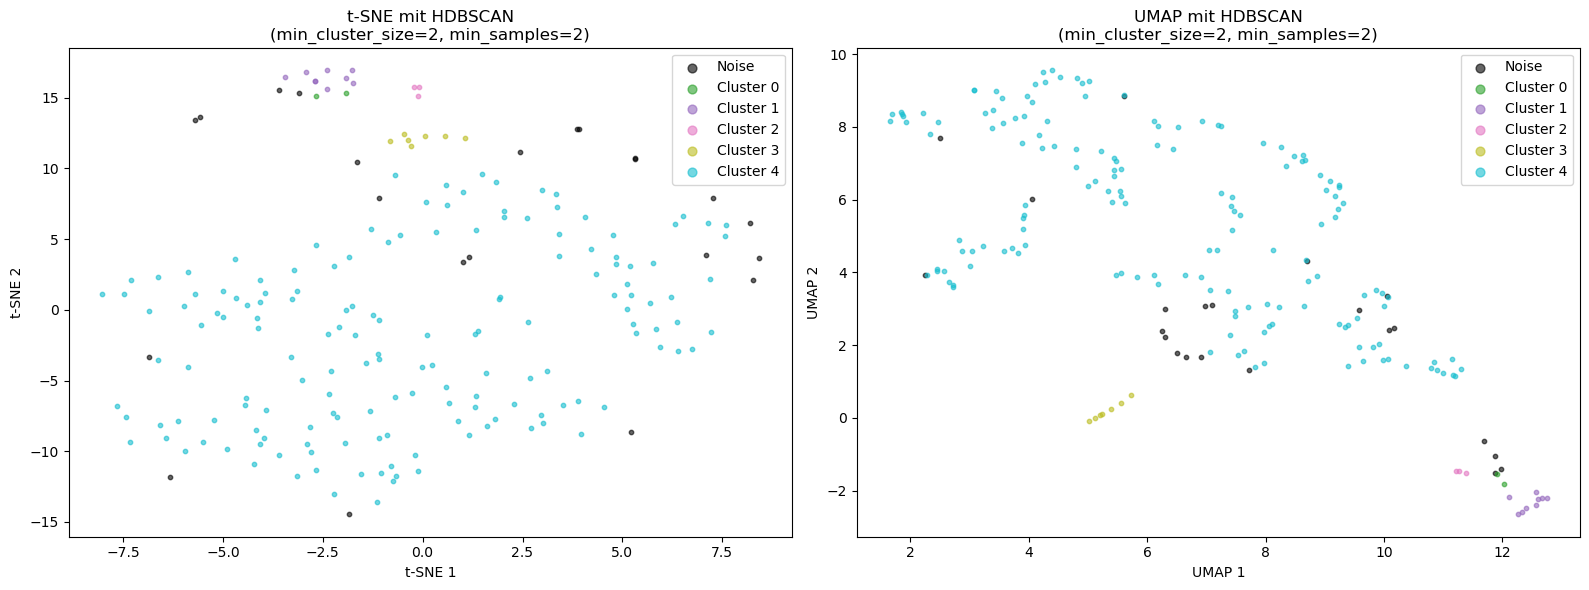

In [33]:

metric = 'euclidean'  # Distanzmetrik für UMAP (und auch für HDBSCAN)

# ---------------------------------------------------
# 2. UMAP-Embedding und t-SNE-Embedding berechnen
# ---------------------------------------------------
# 2.1 UMAP (2D)
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=5,
    min_dist=0.2,
    metric=metric,
    random_state=42
)
X_umap = umap_model.fit_transform(X)

# 2.2 t-SNE (2D)
tsne_model = TSNE(
    n_components=2,
    metric=metric,
    random_state=42
)
X_tsne = tsne_model.fit_transform(X)

# ---------------------------------------------------
# 3. Grid-Search über min_cluster_size und min_samples für HDBSCAN
# ---------------------------------------------------
min_cluster_size_list = np.arange(2, 30, 2)   # z.B. [2, 4, 6, …, 18]
min_samples_list     = np.arange(2, 30, 1)   # z.B. [2, 3, 4, …, 14]
param_grid = {
    'min_cluster_size': min_cluster_size_list,
    'min_samples': min_samples_list
}

grid_data = []
for params in ParameterGrid(param_grid):
    mcs = int(params['min_cluster_size'])
    msp = int(params['min_samples'])

    # Für HDBSCAN: clusterer-Objekt erzeugen
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=msp,
        metric=metric,
        cluster_selection_method='eom',  # Standard: 'eom' (Excess of Mass)
        prediction_data=False            # false reicht für reine Labels
    )
    labels = clusterer.fit_predict(X)  # X (ungescaled oder skaliert? Je nach Anwendungsfall hier X verwenden)

    # Anzahl der echten Cluster (ohne Noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Noise-Anteil
    noise_count = Counter(labels).get(-1, 0)
    noise_ratio = noise_count / len(labels)

    # Nur weiter bewerten, wenn ≥ 5 Cluster und Noise ≤ 30 %
    if (n_clusters < 5) or (noise_ratio > 0.30):
        continue

    # Für ≥ 2 Cluster berechne Davies–Bouldin und Calinski–Harabasz
    if n_clusters >= 2:
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)
    else:
        dbi = np.nan
        chi = np.nan

    grid_data.append({
        'min_cluster_size': mcs,
        'min_samples': msp,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'davies_bouldin': dbi,
        'calinski_harabasz': chi,
        'labels': labels
    })

# ---------------------------------------------------
# 4. Auswahl der besten Parameter
# ---------------------------------------------------
if not grid_data:
    print("Keine Parameterkombination für HDBSCAN mit ≥5 Clustern und ≤30 % Noise gefunden.")
else:
    df = pd.DataFrame(grid_data)
    # Sortiere: 1) DBI klein (ascending=True), 2) CHI groß (ascending=False)
    df_sorted = df.sort_values(
        by=['davies_bouldin', 'calinski_harabasz'],
        ascending=[True, False]
    )
    best = df_sorted.iloc[0]

    print("\nBeste Parameterkombination für HDBSCAN (min. DBI, max. CHI):")
    print(f"min_cluster_size: {best['min_cluster_size']}, min_samples: {best['min_samples']}")
    print(f"Anzahl Cluster: {best['n_clusters']}")
    print(f"Noise-Anteil: {best['noise_ratio']:.2%}")
    print(f"Davies–Bouldin: {best['davies_bouldin']:.3f}")
    print(f"Calinski–Harabasz: {best['calinski_harabasz']:.1f}")

    best_labels = best['labels']

    # ---------------------------------------------------
    # 5. Plot: 1×2 Subplots mit t-SNE und UMAP (mit besten HDBSCAN-Labels)
    # ---------------------------------------------------
    unique_labels = sorted(set(best_labels))
    n_clusters = best['n_clusters']

    # Colormap: tab10 für ≤10 Cluster, sonst tab20
    cmap = plt.get_cmap("tab10") if n_clusters <= 10 else plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}
    color_dict[-1] = (0, 0, 0)  # Noise in Schwarz

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 5.1 t-SNE auf der linken Achse
    ax_tsne = axes[0]
    for label in unique_labels:
        mask = (best_labels == label)
        ax_tsne.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            c=[color_dict[label]],
            label=f'Cluster {label}' if label != -1 else 'Noise',
            alpha=0.6,
            s=10
        )
    ax_tsne.set_title(
        f't-SNE mit HDBSCAN\n(min_cluster_size={best["min_cluster_size"]}, min_samples={best["min_samples"]})'
    )
    ax_tsne.set_xlabel('t-SNE 1')
    ax_tsne.set_ylabel('t-SNE 2')
    ax_tsne.legend(loc='best', markerscale=2)

    # 5.2 UMAP auf der rechten Achse
    ax_umap = axes[1]
    for label in unique_labels:
        mask = (best_labels == label)
        ax_umap.scatter(
            X_umap[mask, 0], X_umap[mask, 1],
            c=[color_dict[label]],
            label=f'Cluster {label}' if label != -1 else 'Noise',
            alpha=0.6,
            s=10
        )
    ax_umap.set_title(
        f'UMAP mit HDBSCAN\n(min_cluster_size={best["min_cluster_size"]}, min_samples={best["min_samples"]})'
    )
    ax_umap.set_xlabel('UMAP 1')
    ax_umap.set_ylabel('UMAP 2')
    ax_umap.legend(loc='best', markerscale=2)

    plt.tight_layout()
    plt.show()
